<a href="https://colab.research.google.com/github/nanekeshishyan/Startups-success-failure-analysis/blob/main/Startups_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dcor

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from math import pi
import dcor

In [ ]:
startups_raw = pd.read_csv('/content/data.csv', encoding='ISO-8859-1')
startups = startups_raw.copy()

In [ ]:
startups.columns.tolist()

In [ ]:
startups.info()

In [ ]:
startups.head()

In [ ]:
startups.tail()

In [ ]:
startups.describe()

In [ ]:
for col in startups.select_dtypes(exclude=['float64', 'int64']).columns:
  if len(startups[col].unique()) == 1:
    startups = startups.drop(columns=col)

len(startups.columns)
#didn't help

In [ ]:
startups = startups.drop_duplicates()
print(f'The number of dublicated rows is: {startups.duplicated().sum()}')

The number of dublicated rows is: 0


In [ ]:
len(startups['Investors'].unique()), startups['Investors'].isna().sum()

In [ ]:
len(startups['Industry of company'].unique()), startups['Industry of company'].isna().sum()

In [ ]:
len(startups['Focus functions of company'].unique()), startups['Focus functions of company'].isna().sum()

In [ ]:
startups

In [ ]:
startups['Focus functions of company'] = startups['Focus functions of company'].str.replace('&', ',')
startups['Focus functions of company'] = startups['Focus functions of company'].replace('\\', np.nan)
startups['Focus functions of company'] = startups['Focus functions of company'].str.replace('mrkting', 'marketing')
startups['Focus functions of company'] = startups['Focus functions of company'].str.replace('software ', 'software')
startups['Focus functions of company'] = startups['Focus functions of company'].str.replace('marketig', 'marketing')
startups['Focus functions of company'] = startups['Focus functions of company'].replace('N', np.nan)
startups['Focus functions of company'] = startups['Focus functions of company'].replace('operation', 'operations')
startups['Focus functions of company'] = startups['Focus functions of company'].str.lower()
startups['Focus functions of company'] = startups['Focus functions of company'].str.replace(r'\s*,\s*', ',', regex=True)

In [ ]:
startups['Focus functions of company']

In [ ]:
len(startups['Focus functions of company'].unique()), startups['Focus functions of company'].isna().sum()

In [ ]:
def histogram_for_unique_values(df, column, threshold):
    data = df[column].str.lower()
    counts = data.value_counts()
    print(counts)

    adjusted_counts = {}
    other_values_counts = {}

    for industry, count in counts.items():
        if count < threshold:
            adjusted_counts['OTHER'] = adjusted_counts.get('OTHER', 0) + count
            other_values_counts[industry] = count
        else:
            adjusted_counts[industry] = count

    plt.figure(figsize=(10, 6))
    pd.Series(adjusted_counts).plot(kind='bar')
    plt.title('Histogram of Frequency of Occurrences')
    plt.xlabel('Column Value')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    #print("Values categorized under 'OTHER' with their occurrences:")
    #for value, count in other_values_counts.items():
        #print(f'{value}: {count}',)


Focus functions of company
operations                                  108
marketing                                    63
analytics                                    33
technology                                   21
marketing,sales                              13
                                           ... 
it,sales                                      1
development,marketing,and administration      1
data collection                               1
social advertising                            1
socialmedia campaign                          1
Name: count, Length: 136, dtype: int64


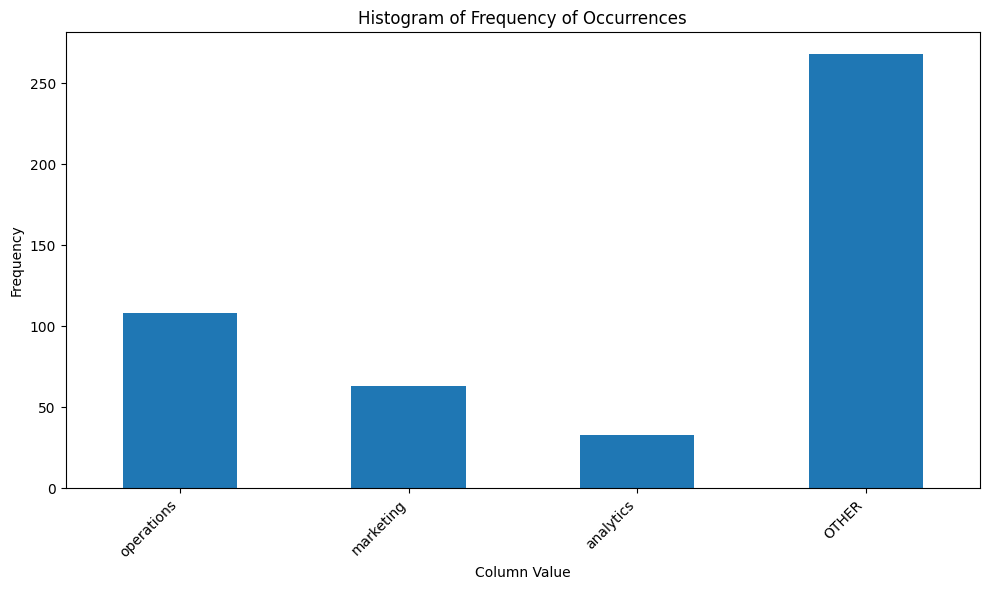

{'operations': 108, 'marketing': 63, 'analytics': 33, 'OTHER': 268}

In [ ]:
histogram_for_unique_values(startups, 'Focus functions of company', 30)

In [ ]:
startups['Industry of company'].unique()

In [ ]:
categories_for_industry = {
        "Technology and Software": ["Analytics", "Cloud Computing", "Software Development", "Mobile", "Security",
                                    "Network / Hosting / Infrastructure", "Enterprise Software", "Telecommunications",
                                    "Mobile|Cloud Computing|Enterprise Software", "Cloud Computing|Analytics",
                                    "Analytics|Mobile|Enterprise Software|Software Development", "Software Development|Analytics",
                                    "Email|Software Development", "Analytics|Software Development", "Cloud Computing|Social Networking|Analytics",
                                    "Cloud Computing|E-Commerce|Classifieds", "Network / Hosting / Infrastructure|Enterprise Software|Software Development|Analytics",
                                    "Cloud Computing|E-Commerce"],
        "Marketing and Advertising": ["Marketing", "Advertising", "Market Research", "Advertising|Marketing",
                                      "Marketing|Enterprise Software|Analytics", "Marketing|Analytics", "Advertising|Market Research",
                                      "Marketing|Mobile|E-Commerce", "Marketing|Media|Analytics|Advertising", "Advertising|Entertainment|Media|Analytics",
                                      "Advertising|E-Commerce|Analytics|Marketing", "Marketing|E-Commerce|Analytics|Mobile|Advertising"],
        "E-Commerce and Retail": ["E-Commerce", "Retail", "E-Commerce|Retail", "Mobile|Retail", "E-Commerce|Mobile",
                                  "Advertising|Retail|Mobile", "E-Commerce|Retail|Marketing|Mobile|Advertising|Deals",
                                  "E-Commerce|Retail|Analytics", "E-Commerce|Analytics|Mobile|Retail", "E-Commerce|Publishing|Marketing",
                                  "E-Commerce|Food & Beverages", "E-Commerce|Network / Hosting / Infrastructure", "Retail|Mobile",
                                  "Retail|Analytics"],
        "Healthcare and Pharmaceuticals": ["Healthcare", "Pharmaceuticals", "Healthcare|Pharmaceuticals|Analytics",
                                           "Healthcare|Analytics", "Healthcare|Market Research|Mobile", "Healthcare|Analytics|Mobile|Food & Beverages"],
        "Media and Entertainment": ["Media", "Entertainment", "Publishing", "Media|Finance|Marketing", "Media|Advertising|Marketing",
                                    "Media|Entertainment", "Music", "Gaming", "Media|Publishing", "Entertainment|Media|Mobile",
                                    "Gaming|Entertainment", "Music|Media|Software Development", "Entertainment|Media"],
        "Others": ["Social Networking", "Real Estate", "Transportation", "Human Resources (HR)", "Career / Job Search",
                   "Education", "Government", "Insurance", "Space Travel", "Travel|Deals|Analytics|Hospitality",
                   "Classifieds|Network / Hosting / Infrastructure", "Analytics|Government", "Analytics|Entertainment",
                   "Music|Search|Analytics", "Social Networking|Music|Entertainment|Media", "Email", "Search",
                   "Gaming|CleanTech|Social Networking|Energy", "Food & Beverages", "E-Commerce|Food & Beverages|Mobile", "Network / Hosting / Infrastructure|Food & Beverages|Analytics",
                             "Analytics|Food & Beverages|Social Networking|Mobile", "Energy", "CleanTech|Energy", "E-Commerce|Energy|Media", "CleanTech|Analytics|Energy",
                                 "Cloud Computing|Energy", "Energy|Analytics", "CleanTech|Analytics|Real Estate|Energy"]
    }


In [ ]:
def categorize_and_plot(df, column, categories):
    column = df['Industry of company'].dropna()
    category_counts = {category: 0 for category in categories.keys()}
    for entry in column:
        categorized = False
        for category, keywords in categories.items():
            if any(keyword in entry for keyword in keywords):
                category_counts[category] += 1
                categorized = True
                break
        if not categorized:
            category_counts["Others"] += 1


    plt.figure(figsize=(10, 8))
    plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
    plt.xticks(rotation=45, ha="right")
    plt.title('Frequency of Startups by Category')
    plt.ylabel('Frequency')
    plt.xlabel('Categories')
    plt.tight_layout()
    plt.show()

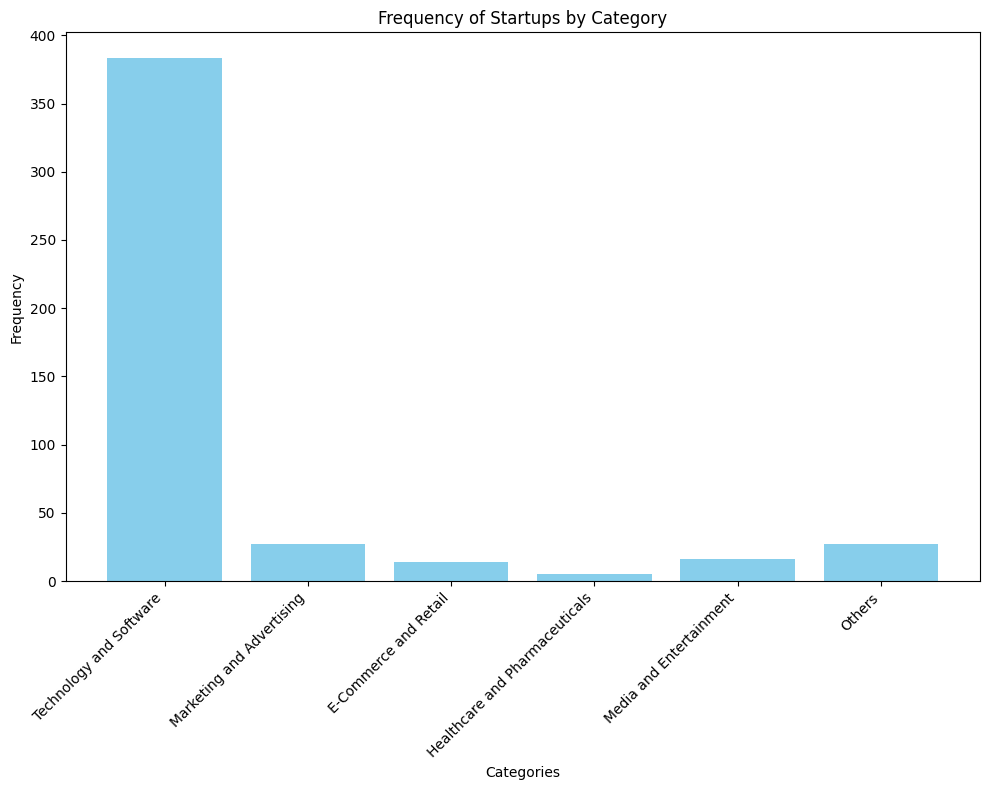

In [ ]:
categorize_and_plot(startups, startups['Industry of company'], categories_for_industry)

In [ ]:
most_frequent_in_focus = startups['Focus functions of company'].mode()[0]
startups['Focus functions of company'] = startups['Focus functions of company'].fillna(most_frequent_in_focus)
startups['Focus functions of company'].isna().sum()

In [ ]:
most_frequent_in_industry = startups['Industry of company'].mode()[0]
startups['Industry of company'] = startups['Industry of company'].fillna(most_frequent_in_industry)
startups['Industry of company'].isna().sum()


In [ ]:
print(f"unique values of industry: {startups['Industry of company'].unique()}, \n\n unique values of focus function: {startups['Focus functions of company'].unique()}")

In [ ]:
columns_to_remove = [
    'Continent of company', 'Last Funding Date', 'Est. Founding Date',
    'Investors', 'Short Description of company profile', 'Company_Name',
    'Age of company in years',
    'Percent_skill_Entrepreneurship','Percent_skill_Engineering',
    'Percent_skill_Marketing', 'Percent_skill_Leadership', 'Percent_skill_Data Science',
    'Percent_skill_Business Strategy', 'Percent_skill_Product Management', 'Percent_skill_Sales',
    'Percent_skill_Domain', 'Percent_skill_Law', 'Percent_skill_Consulting', 'Percent_skill_Finance',
    'Percent_skill_Investment', 'Top management similarity',
    'Proprietary or patent position (competitive position)', 'Legal risk and intellectual property',
    'Have been part of startups in the past?', 'Consulting experience?', 'Was he or she partner in Big 5 consulting?',
    'Focus on structured or unstructured data', 'Focus on consumer data?', 'Focus on private or public data?',
    'Capital intensive business e.g. e-commerce, Engineering products and operations can also cause a business to be capital intensive',
    'Linear or Non-linear business model', 'Local or global player', 'Predictive Analytics business',
    'Speech analytics business', 'Prescriptive analytics business', 'Big Data Business',
    'Cross-Channel Analytics/ marketing channels', 'Owns data or not? (monetization of data) e.g. Factual', 'Highest education',
    'Breadth of experience across verticals', 'Exposure across the globe',
    "Top forums like 'Tech crunch' or 'Venture beat' talking about the company/model - How much is it being talked about?",
    'Specialization of highest education', 'Years of education', 'Highest education', 'Experience in Fortune 1000 organizations',
    'Experience in Fortune 500 organizations', 'Experience in Fortune 100 organizations', 'Renowned in professional circle',
    'Degree from a Tier 1 or Tier 2 university?', 'Number of Recognitions for Founders and Co-founders',
    'Top management similarity', 'Number of Recognitions for Founders and Co-founders', 'Skills score',
    'Number of Investors in Seed', 'Number of Investors in Angel and or VC', 'Team size Senior leadership',
    'Team size all employees', 'Worked in top companies', 'Average size of companies worked for in the past',
    'Legal risk and intellectual property', 'google page rank of company website',
    'Technical proficiencies to analyse and interpret unstructured data','Invested through global incubation competitions?',
    'Industry trend in investing', 'Gartner hype cycle stage', 'Time to maturity of technology (in years)'
]


startups = startups.drop(columns=columns_to_remove)

In [ ]:
pd.set_option('display.max_columns', None)
startups

In [ ]:
for col in startups.select_dtypes(include=['float64', 'int64']).columns:
  if startups[col].isna().any() and startups[col].isna().sum() < 0.2 * len(startups):
    startups[col].fillna(startups[col].mean(), inplace=True)

  elif startups[col].isna().sum() >= 0.2 * len(startups):
    print(col)


Employee Count
Employees count MoM change
Last Funding Amount


In [ ]:
for col in startups.select_dtypes(include=['float64', 'int64']).columns:
  print(col, startups[col].isna().sum())

Internet Activity Score 65
Employee Count 166
Employees count MoM change 205
Last Funding Amount 160
Number of Co-founders 0
Number of of advisors 0


In [ ]:
startups['Employee Count'].tolist()

In [ ]:
startups['Employees count MoM change'].tolist()

In [ ]:
startups['Last Funding Amount'].tolist()

In [ ]:
startups = startups.drop(columns=['Employees count MoM change'])

mean_employee_count = startups['Employee Count'].mean()
startups['Employee Count'] = startups['Employee Count'].fillna(mean_employee_count)

mean_funding_amount = startups['Last Funding Amount'].mean()
startups['Last Funding Amount'] = startups['Last Funding Amount'].fillna(mean_funding_amount)

In [ ]:
startups['Last Funding Amount'].isna().sum(), startups['Employee Count'].isna().sum()

In [ ]:
startups['Number of of advisors'].tolist()

In [ ]:
'''count = 0
for value in startups['Number of of advisors']:
  if value == 0:
    count += 1
  else:
    continue

count
#303 of 472 are zeros, so this column isn't valuable'''

In [ ]:
#startups = startups.drop(columns=['Number of of advisors'])

<Axes: >

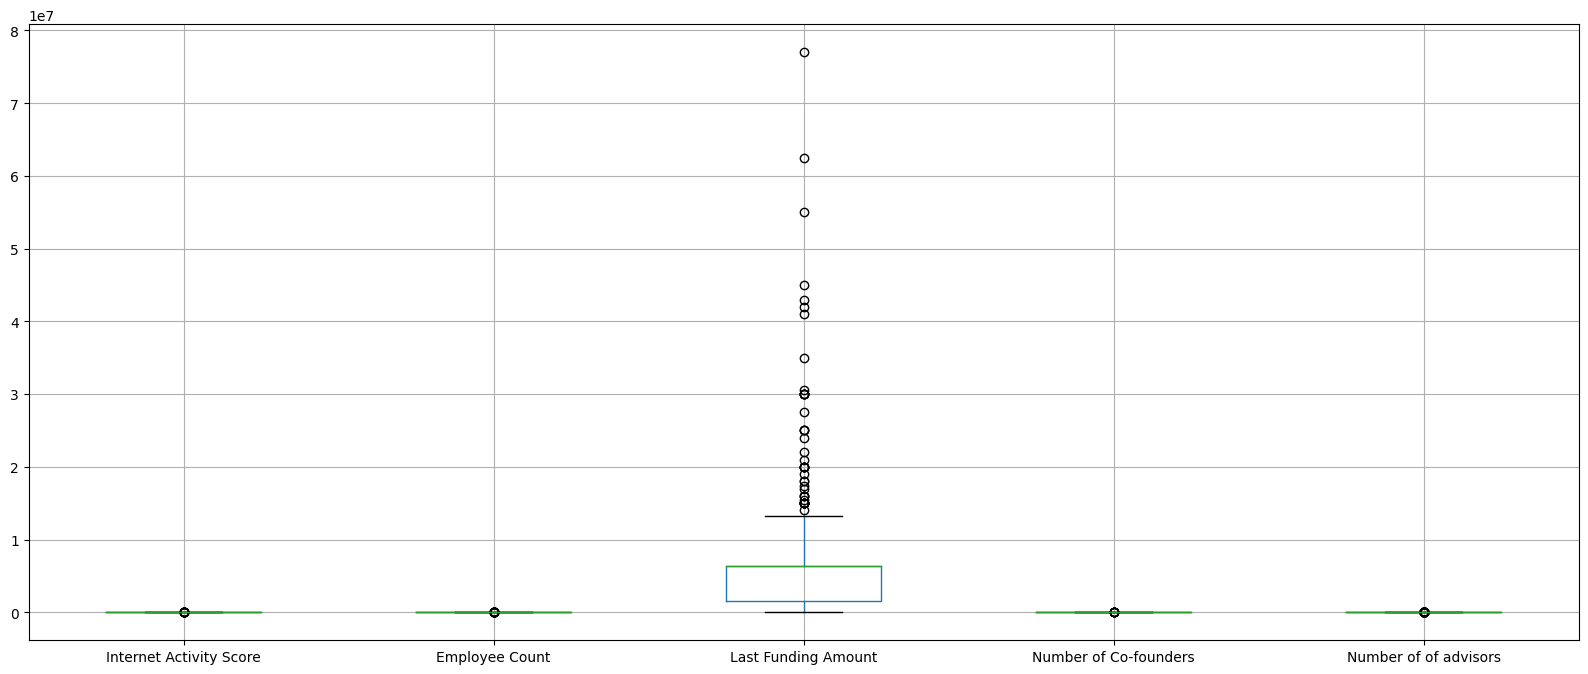

In [ ]:
startups.boxplot(figsize=(20, 8))

In [ ]:
def number_of_outliers(column):
  Q1 = column.quantile(0.25)
  Q3 = column.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  upper_outliers_sum = (column > upper_bound).sum()
  lower_outliers_sum = (column < lower_bound).sum()

  return upper_outliers_sum, lower_outliers_sum


def outliers_removal(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
  df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])

  return df[column]

In [ ]:
startups.select_dtypes(include=['float64', 'int64'])

In [ ]:
startups['Employee Count'] = startups['Employee Count'].astype(int)

In [ ]:
print(number_of_outliers(startups['Last Funding Amount']))

(0, 0)


In [ ]:
startups['Last Funding Amount'] =  outliers_removal(startups, 'Last Funding Amount')

In [ ]:
startups['Dependent-Company Status'].value_counts(), startups['year of founding'].value_counts()

In [ ]:
mode_of_year = startups['year of founding'].mode()[0]
startups['year of founding'].isna().sum()

0

In [ ]:
startups['year of founding'] = startups['year of founding'].str.replace('No Info', mode_of_year)
startups['year of founding'] = pd.to_numeric(startups['year of founding'])

In [ ]:
startups['Country of company'] = startups['Country of company'].fillna(startups['Country of company'].mode()[0])
startups['Country of company'].isna().sum(), startups['Country of company'].value_counts()

In [ ]:
startups['Presence of a top angel or venture fund in previous round of investment'].isna().sum(),  startups['Presence of a top angel or venture fund in previous round of investment'].value_counts()
#decided to leave 'No Info' as a separate category to see if there's any pattern connected with it

In [ ]:
startups['Number of of repeat investors'].value_counts()
startups['Number of of repeat investors'] = startups['Number of of repeat investors'].str.replace('No Info', '0')
startups['Number of of repeat investors'] = pd.to_numeric(startups['Number of of repeat investors'])

In [ ]:
startups['Has the team size grown'].value_counts(), startups['Has the team size grown'].isna().sum()

In [ ]:
startups['Has the team size grown'] = startups['Has the team size grown'].str.replace('Yes', 'yes')
startups['Has the team size grown'] = startups['Has the team size grown'].str.replace('YES', 'yes')
startups['Has the team size grown'] = startups['Has the team size grown'].str.replace('No Info', 'No')
startups['Has the team size grown'] = startups['Has the team size grown'].fillna('No')

In [ ]:
startups['Have been part of successful startups in the past?'].value_counts(), startups['Have been part of successful startups in the past?'].isna().sum()

In [ ]:
startups['Have been part of successful startups in the past?'] = startups['Have been part of successful startups in the past?'].str.replace('No Info', 'Yes')

In [ ]:
startups['Product or service company?'].value_counts(), startups['Product or service company?'].isna().sum()
startups['Product or service company?'] = startups['Product or service company?'].str.replace('No Info', 'Service')

In [ ]:
startups['Catering to product/service across verticals'].value_counts(), startups['Subscription based business'].value_counts()
startups['Catering to product/service across verticals'] = startups['Catering to product/service across verticals'].str.replace('No Info', 'No')
startups['Subscription based business'] = startups['Subscription based business'].str.replace('No Info', 'Yes')

In [ ]:
startups['Cloud or platform based serive/product?'].value_counts(), startups['Cloud or platform based serive/product?'].isna().sum()

In [ ]:
startups['Cloud or platform based serive/product?'] = startups['Cloud or platform based serive/product?'].str.replace('cloud', 'Cloud')
startups['Cloud or platform based serive/product?'] = startups['Cloud or platform based serive/product?'].str.replace('none', 'No Info')
# decided to leave No Info as a separate category to see if there's any pattern connected with it

In [ ]:
startups['Crowdsourcing based business'].value_counts(), startups['Crowdfunding based business'].value_counts(), startups['Crowdsourcing based business'].isna().sum(), startups['Crowdfunding based business'].isna().sum()

In [ ]:
startups['Crowdfunding based business'] = startups['Crowdfunding based business'].str.replace('No Info', 'No')
startups['Crowdsourcing based business'] = startups['Crowdsourcing based business'].str.replace('No Info', 'No')

In [ ]:
startups['Machine Learning based business'].value_counts(), startups['Is the company an aggregator/market place? e.g. Bluekai'].value_counts(), startups['Machine Learning based business'].isna().sum(), startups['Is the company an aggregator/market place? e.g. Bluekai'].isna().sum()

In [ ]:
startups['Machine Learning based business'] = startups['Machine Learning based business'].str.replace('No Info', 'No')
startups['Is the company an aggregator/market place? e.g. Bluekai'] = startups['Is the company an aggregator/market place? e.g. Bluekai'].str.replace('No Info', 'No')

In [ ]:
startups['Online or offline venture - physical location based business or online venture?'].value_counts(), startups['Online or offline venture - physical location based business or online venture?'].isna().sum()
startups['Online or offline venture - physical location based business or online venture?'] = startups['Online or offline venture - physical location based business or online venture?'].str.replace('No Info', 'Online')

In [ ]:
startups['B2C or B2B venture?'].value_counts(), startups['B2C or B2B venture?'].isna().sum()
startups['B2C or B2B venture?'] = startups['B2C or B2B venture?'].str.replace('No Info', 'B2B')

In [ ]:
startups['Average Years of experience for founder and co founder'].value_counts(), startups['Relevance of education to venture'].value_counts(), startups['Relevance of experience to venture'].value_counts()
#decided to leave No Info as a separate category to see if there's any pattern connected with it

In [ ]:
startups['Experience in selling and building products'].value_counts(), startups['Experience in selling and building products'].isna().sum()
startups['Experience in selling and building products'] = startups['Experience in selling and building products'].fillna('No Info')

In [ ]:
startups['Team Composition score'].value_counts(), startups['Team Composition score'].isna().sum()
#decided to leave No Info as a separate category to see if there's any pattern connected with it

In [ ]:
startups['Dificulty of Obtaining Work force'].value_counts(), startups['Dificulty of Obtaining Work force'].isna().sum()
#decided to leave No Info as a separate category to see if there's any pattern connected with it

In [ ]:
startups['Pricing Strategy'].value_counts(), startups['Pricing Strategy'].isna().sum()
#decided to leave No Info as a separate category to see if there's any pattern connected with it

In [ ]:
startups['Hyper localisation'].value_counts(), startups['Hyper localisation'].isna().sum()
#decided to leave No Info as a separate category to see if there's any pattern connected with it

In [ ]:
startups['Time to market service or product'].value_counts(), startups['Time to market service or product'].isna().sum()
#decided to leave No Info as a separate category to see if there's any pattern connected with it

In [ ]:
startups['Employee benefits and salary structures'].value_counts(), startups['Employee benefits and salary structures'].isna().sum()
#too many no info-s
startups = startups.drop(columns=['Employee benefits and salary structures'])

In [ ]:
startups['Long term relationship with other founders'].value_counts(), startups['Long term relationship with other founders'].isna().sum()
#decided to leave No Info as a separate category to see if there's any pattern connected with it

In [ ]:
startups['Barriers of entry for the competitors'].value_counts(), startups['Barriers of entry for the competitors'].isna().sum()

In [ ]:
startups['Company awards'].value_counts(), startups['Company awards'].isna().sum()
#decided to leave No Info as a separate category to see if there's any pattern connected with it

In [ ]:
startups['Controversial history of founder or co founder'].value_counts(), startups['Controversial history of founder or co founder'].isna().sum()
#this column isn't representative as the majority of the values are 'No'
startups = startups.drop(columns=['Controversial history of founder or co founder'])

In [ ]:
startups['Client Reputation'].value_counts(), startups['Client Reputation'].isna().sum()
#too many no info-s
startup = startups.drop(columns=['Client Reputation'])

In [ ]:
startups['Solutions offered'].value_counts(), startups['Solutions offered'].isna().sum()
#decided to leave No Info as a separate category to see if there's any pattern connected with it

In [ ]:
startups['Disruptiveness of technology'].value_counts(), startups['Disruptiveness of technology'].isna().sum()
#decided to leave No Info as a separate category to see if there's any pattern connected with it

In [ ]:
startups['Number of Direct competitors'].value_counts(), startups['Number of Direct competitors'].isna().sum()
startups['Number of Direct competitors'] = startups['Number of Direct competitors'].str.replace('No Info', '0')
startups['Number of Direct competitors'] = pd.to_numeric(startups['Number of Direct competitors'])
startups['Number of Direct competitors'].value_counts()

In [ ]:
#it's an average of the number of employees hired by the company
startups['Employees per year of company existence'].value_counts(), startups['Employees per year of company existence'].isna().sum()
#too many no info-s
startups = startups.drop(columns=['Employees per year of company existence'])

In [ ]:
startups['Last round of funding received (in milionUSD)'].value_counts()
startups = startups.drop(columns=['Last round of funding received (in milionUSD)'])
#too many no info-s

In [ ]:
startups['Survival through recession, based on existence of the company through recession times'].value_counts()
#recession isn't applicable to the majority of companies, and the second most frequent value is No Info
startups = startups.drop(columns=['Survival through recession, based on existence of the company through recession times'])

In [ ]:
startups['Time to 1st investment (in months)'].value_counts(), startups['Time to 1st investment (in months)'].isna().sum()

In [ ]:
startups['Time to 1st investment (in months)'] = startups['Time to 1st investment (in months)'].str.replace('No Info', '1')
startups['Time to 1st investment (in months)'] = pd.to_numeric(startups['Time to 1st investment (in months)'])

In [ ]:
startups['Avg time to investment - average across all rounds, measured from previous investment'].value_counts(), startups['Avg time to investment - average across all rounds, measured from previous investment'].isna().sum()
#too many No Info-s, impossible to make it a numeric column
startups = startups.drop(columns=['Avg time to investment - average across all rounds, measured from previous investment'])

In [ ]:
startups['Percent_skill_Operations'].value_counts(), startups['Percent_skill_Operations'].isna().sum()
#too many No-Info-s, more than half have no skills in operations, whereas 'operations' is the nost frequent focus function
startups = startups.drop(columns=['Percent_skill_Operations'])

In [ ]:
startups['Renown score'].value_counts(), startups['Renown score'].isna().sum()
#too many No-Info-s and zeroes
startups = startups.drop(columns=['Renown score'])

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
startups

In [ ]:
len(startups.select_dtypes(include=['object']).columns), len(startups.select_dtypes(exclude=['object']).columns)

(36, 9)

In [ ]:
startups1 = startups.copy()

In [ ]:
startups.boxplot(figsize=(25, 10))
plt.xticks(rotation=45, ha="right");

In [ ]:
startups['Internet Activity Score'].isna().sum()
startups['Internet Activity Score'] = startups['Internet Activity Score'].fillna(startups['Internet Activity Score'].mean())

In [ ]:
label_encoder = LabelEncoder()
startups['Dependent-Company Status'] = label_encoder.fit_transform(startups['Dependent-Company Status'])
startups

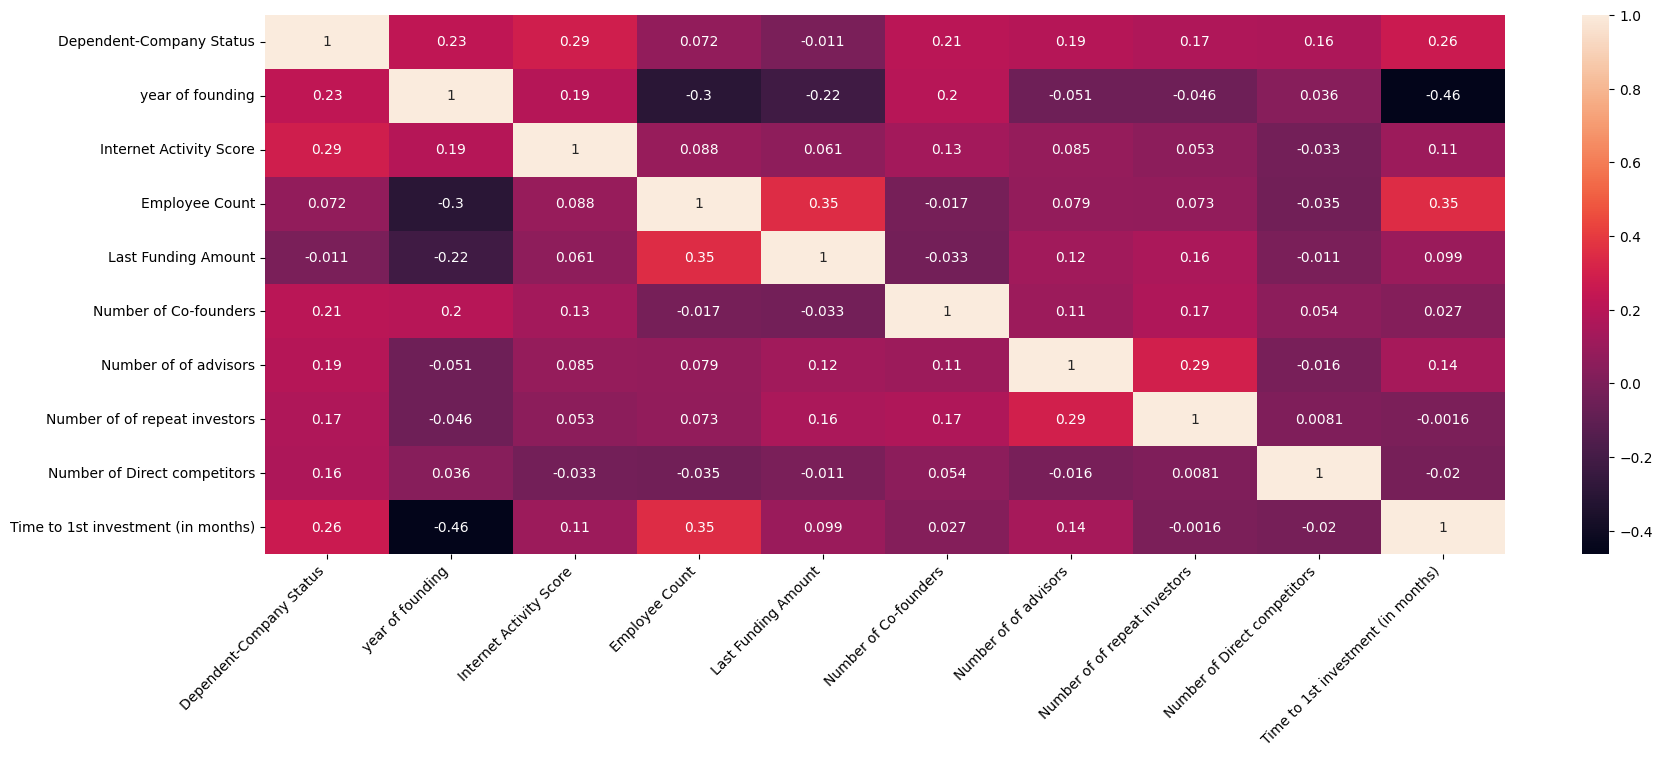

In [ ]:
corr_matrix = startups.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr_matrix, annot=True)
plt.rcParams['figure.figsize'] = (20, 7)
plt.xticks(rotation=45, ha="right")
plt.show()

In [ ]:
#looking for correlations when one of the columns is binary and another is continuous

corr_internet_activity_score = stats.pointbiserialr(startups['Dependent-Company Status'], startups['Internet Activity Score'])
corr_investment = stats.pointbiserialr(startups['Dependent-Company Status'], startups['Time to 1st investment (in months)'])

print(f'Correlation with internet activity score: {corr_internet_activity_score.correlation}, pvalue: {corr_internet_activity_score.pvalue}')
print(f'Correlation with investment: {corr_investment.correlation}, pvalue: {corr_investment.pvalue}')

Correlation with internet activity score: 0.2912979194166299, pvalue: 1.1017834409779038e-10
Correlation with investment: 0.2647325758105561, pvalue: 5.196920866888673e-09


In [ ]:
startups2 = startups.select_dtypes(exclude=['object']).groupby('Dependent-Company Status').mean()

,year of founding,Internet Activity Score,Employee Count,Last Funding Amount,Number of Co-founders,Number of of advisors,Number of of repeat investors,Number of Direct competitors,Time to 1st investment (in months)
Dependent-Company Status,,,,,,,,,
0,2008.718563,31.772617,26.329341,5.309543e+06,1.550898,0.502994,0.281437,0.958084,5.550898
1,2009.881967,159.270012,33.967213,5.216624e+06,2.042623,1.298361,0.704918,2.377049,15.281967


In [ ]:
#distant correlation finds both linear and non-linear relationships

for col in startups.select_dtypes(exclude=['object']):
  print(col, dcor.distance_correlation(startups[col], startups['Dependent-Company Status']))

#tge most correlated are internet activity score, year of founding, time to 1st investment

Dependent-Company Status 1.0
year of founding 0.2744230632777665
Internet Activity Score 0.34310791705353444
Employee Count 0.1629804052362217
Last Funding Amount 0.09522273694964278
Number of Co-founders 0.2287402805269972
Number of of advisors 0.1929627601410972
Number of of repeat investors 0.19563897129326874
Number of Direct competitors 0.21175708494079118
Time to 1st investment (in months) 0.34284895146111893


/usr/local/lib/python3.10/dist-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(int64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


In [ ]:
startups.select_dtypes(include=['float64', 'int64', 'object'])

FREQUENCY OF GROUPPED INDUSTRIES FOR SUCCESSFUL COMPANIES: 



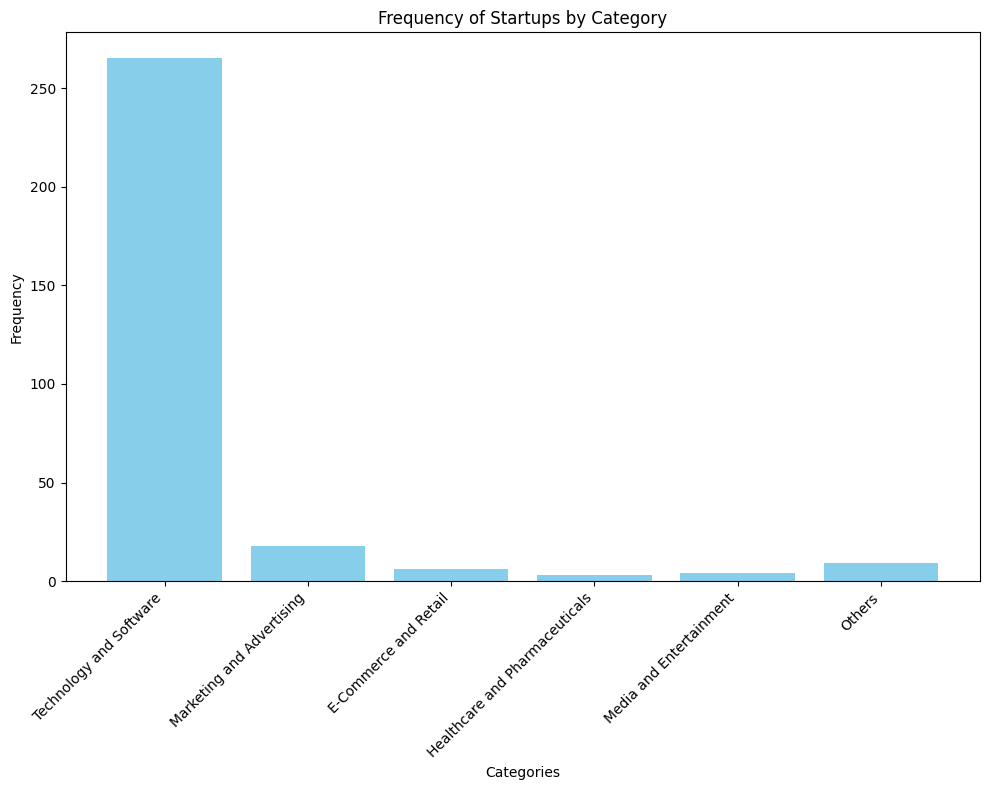

{None}
 
FREQUENCY OF GROUPPED INDUSTRIES FOR FAILED COMPANIES: 



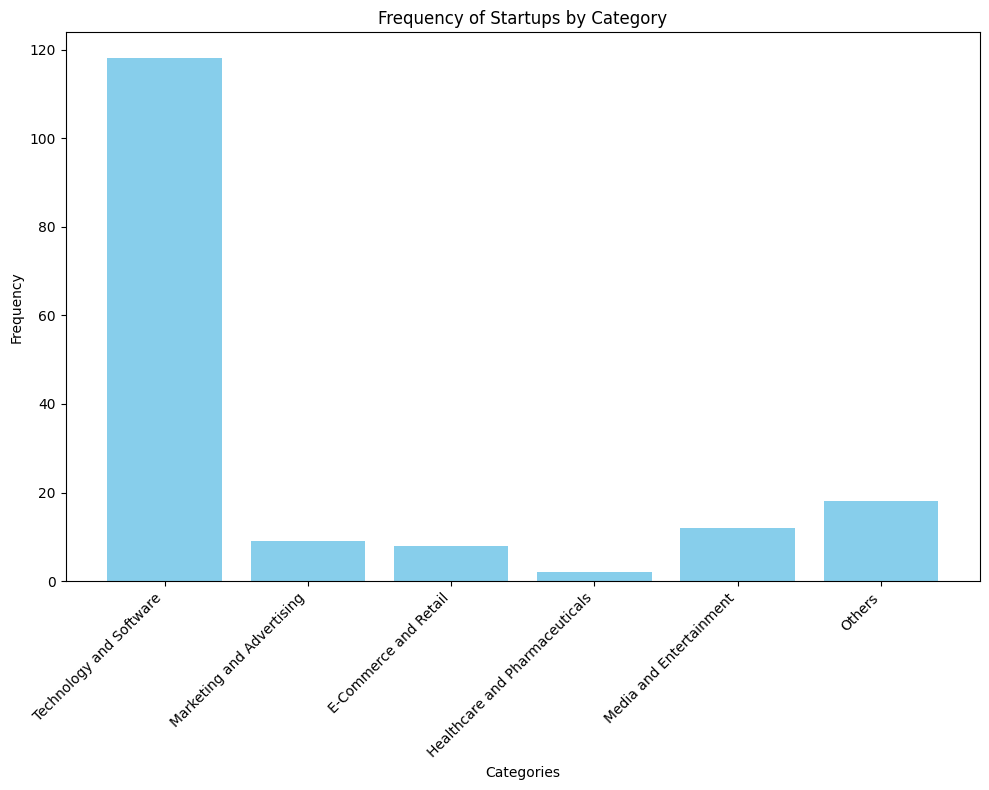

None


In [ ]:
startups_successful = startups[startups['Dependent-Company Status'] == 1]
print('FREQUENCY OF GROUPPED INDUSTRIES FOR SUCCESSFUL COMPANIES: \n')
print({categorize_and_plot(startups_successful, startups['Industry of company'], categories_for_industry)})


print(' \nFREQUENCY OF GROUPPED INDUSTRIES FOR FAILED COMPANIES: \n')
startups_failed = startups[startups['Dependent-Company Status'] == 0]
print(categorize_and_plot(startups_failed, startups['Industry of company'], categories_for_industry))

FREQUENCY OF GROUPPED FOCUS FUNCTIONS FOR SUCCESSFUL COMPANIES: 

Focus functions of company
marketing                                           47
operations                                          43
analytics                                           23
technology                                          21
marketing,sales                                     11
                                                    ..
data visualization                                   1
retail                                               1
intellectual property analysis and visualisation     1
app revenue                                          1
social                                               1
Name: count, Length: 106, dtype: int64


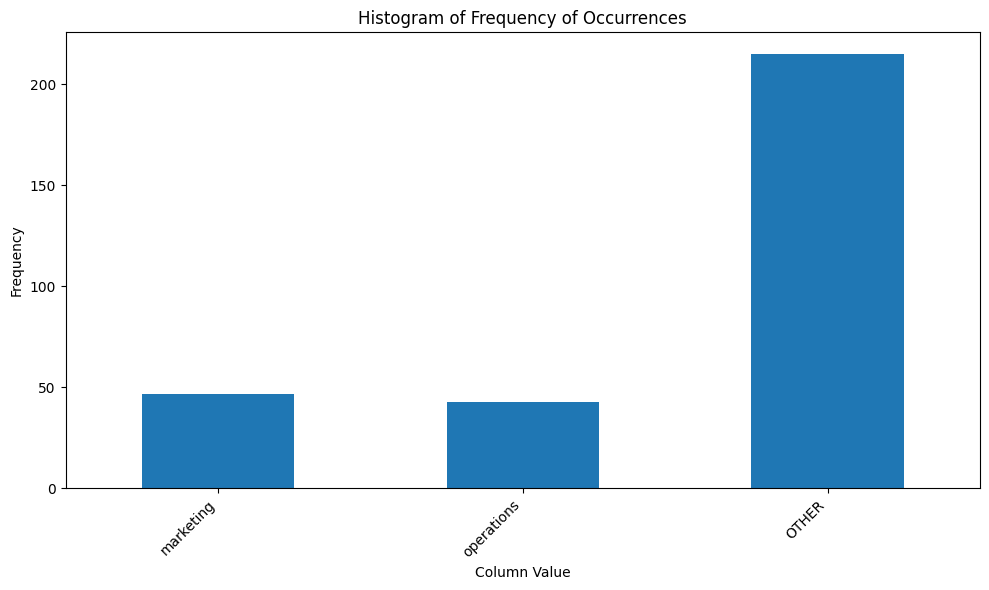

{'marketing': 47, 'operations': 43, 'OTHER': 215} 20
FREQUENCY OF GROUPPED FOCUS FUNCTION FOR FAILED COMPANIES: 

Focus functions of company
operations                                  65
marketing                                   16
analytics                                   10
advertising                                  9
web                                          5
software                                     5
sales                                        4
curated web                                  4
entertainment                                3
sale                                         3
marketing,sales                              2
game                                         2
networking                                   2
search                                       2
sales,marketing                              2
consumer web                                 2
social network                               2
music                                        1
enterprise   

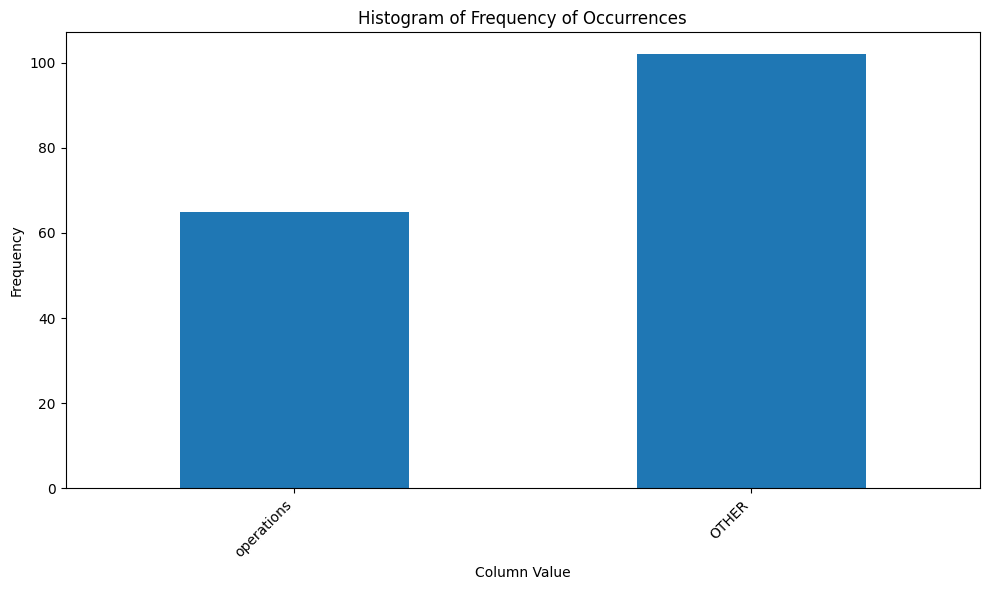

{'operations': 65, 'OTHER': 102} 10


In [ ]:
print('FREQUENCY OF GROUPPED FOCUS FUNCTIONS FOR SUCCESSFUL COMPANIES: \n')
print(histogram_for_unique_values(startups_successful, 'Focus functions of company'), 20)

print('FREQUENCY OF GROUPPED FOCUS FUNCTION FOR FAILED COMPANIES: \n')
print(histogram_for_unique_values(startups_failed, 'Focus functions of company'), 10)

In [ ]:
startups.select_dtypes(include=['object'])

In [ ]:
#It's impossible to address to 'Number of of Partners of company', 'Number of of Research publications' by their names, so I couldn't drop or clean them
pd.set_option('display.max_columns', None)
startups_categorical = startups.select_dtypes(include=['object']).drop(['Focus functions of company', 'Industry of company'], axis=1)
startups_categorical

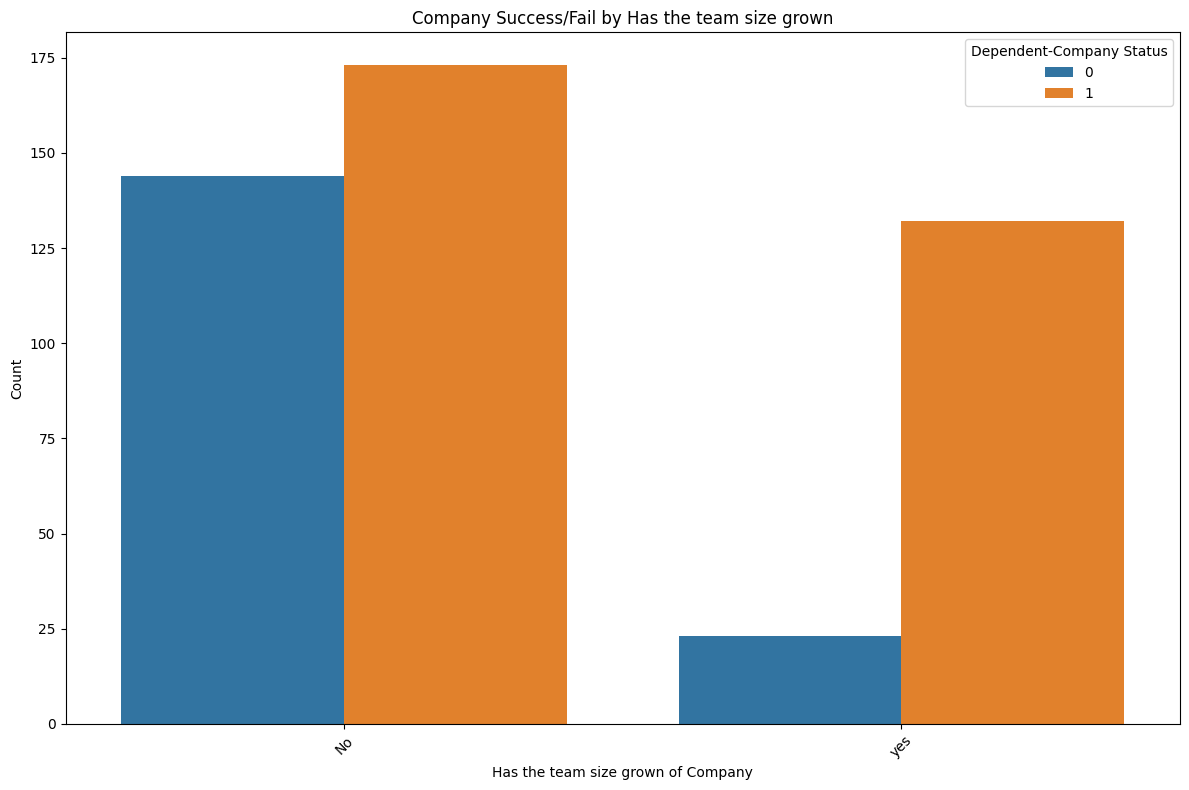

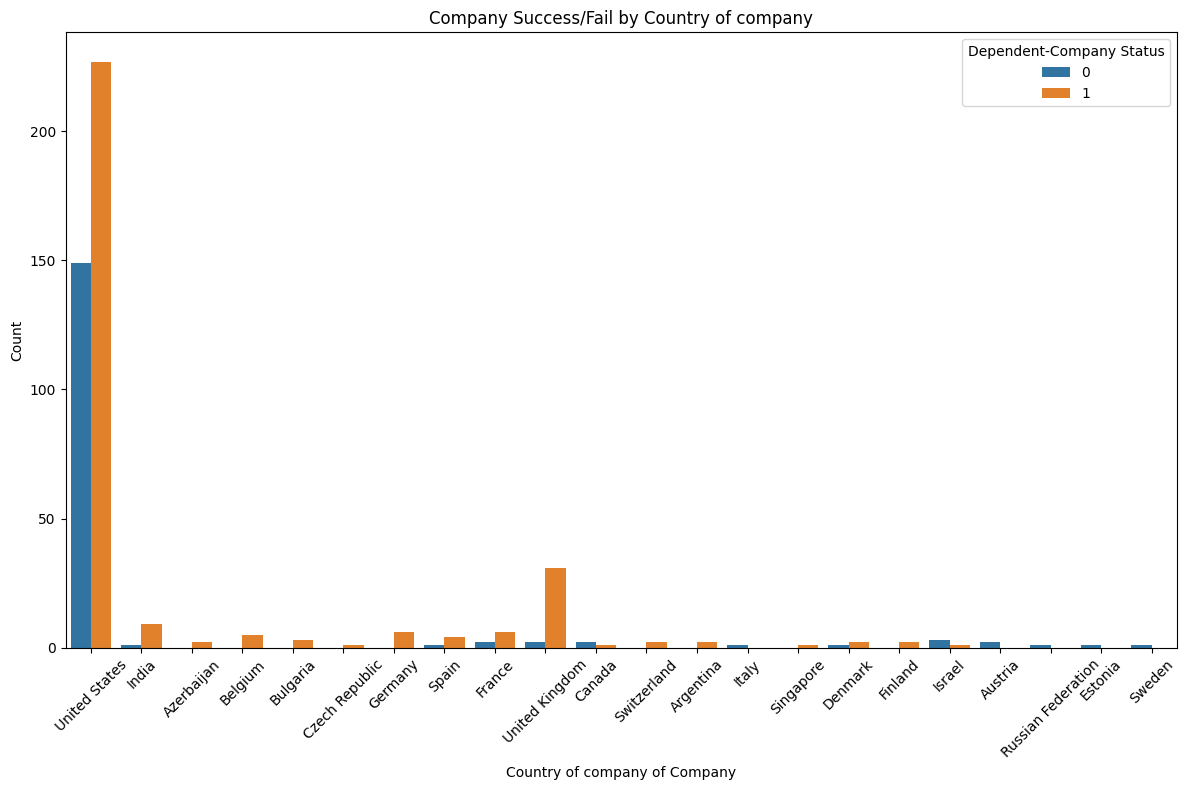

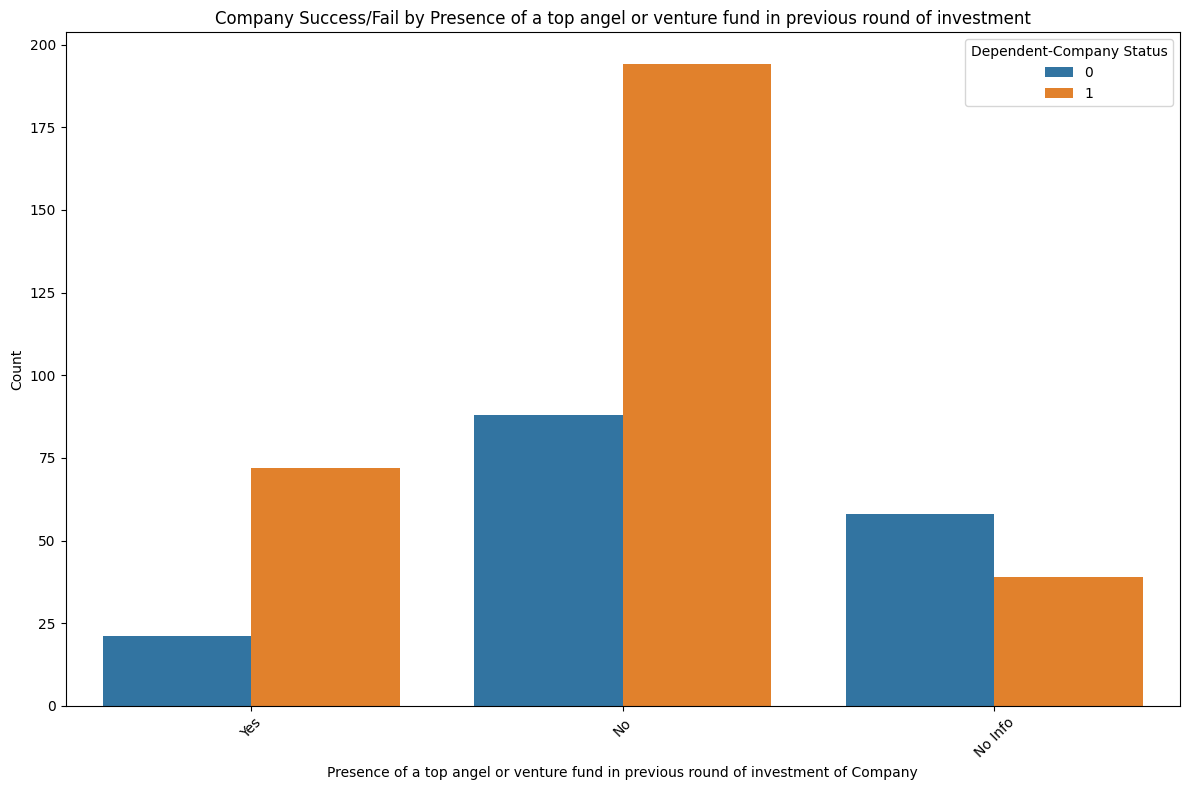

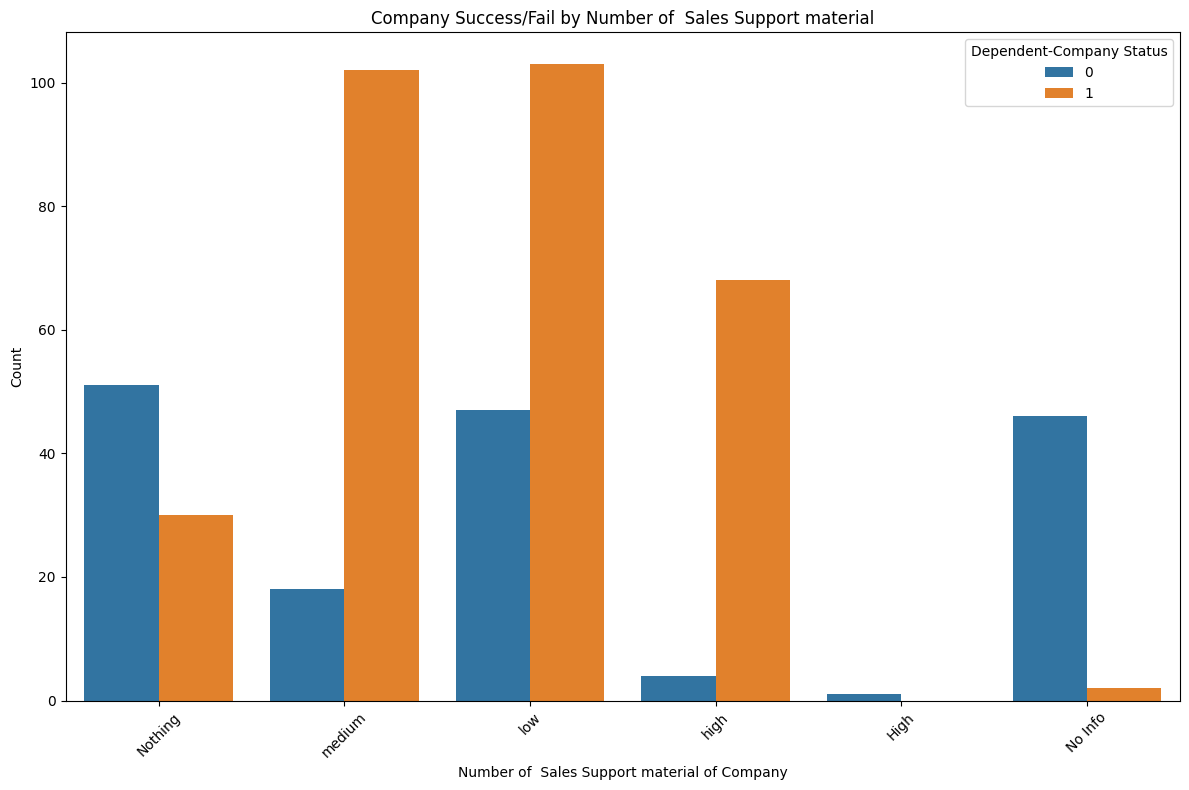

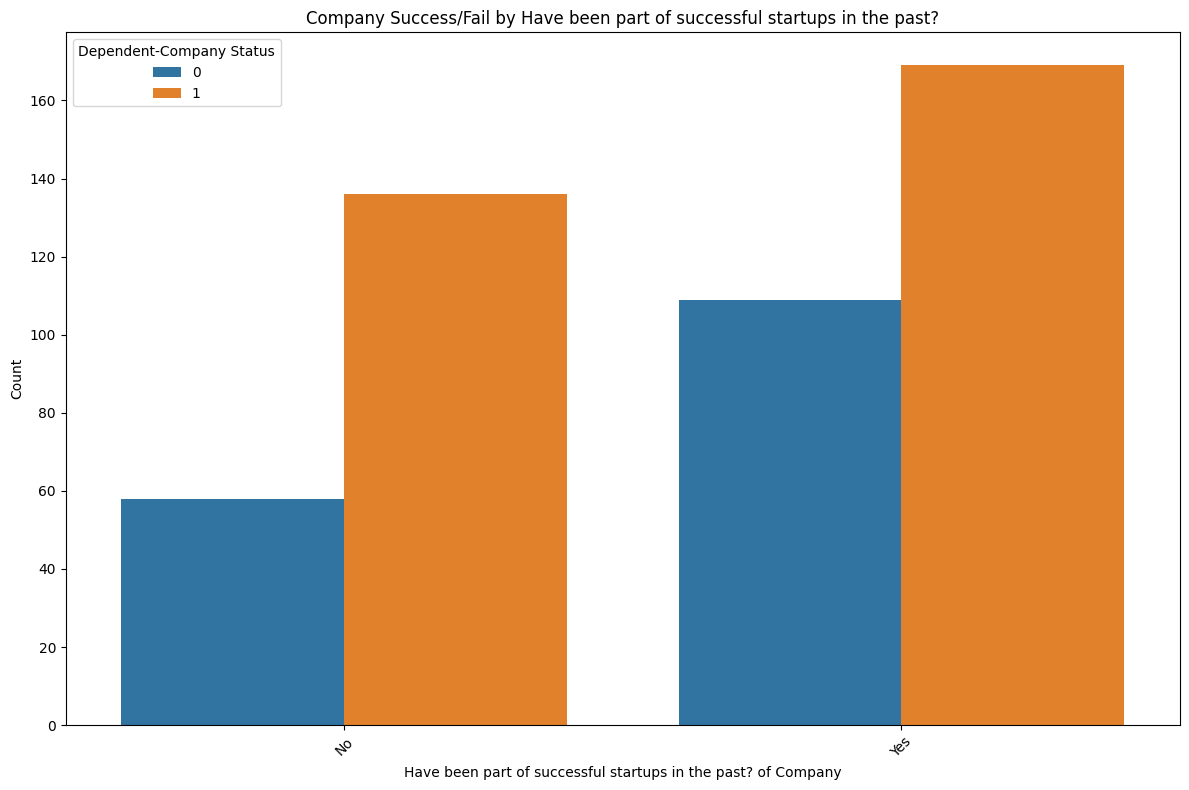

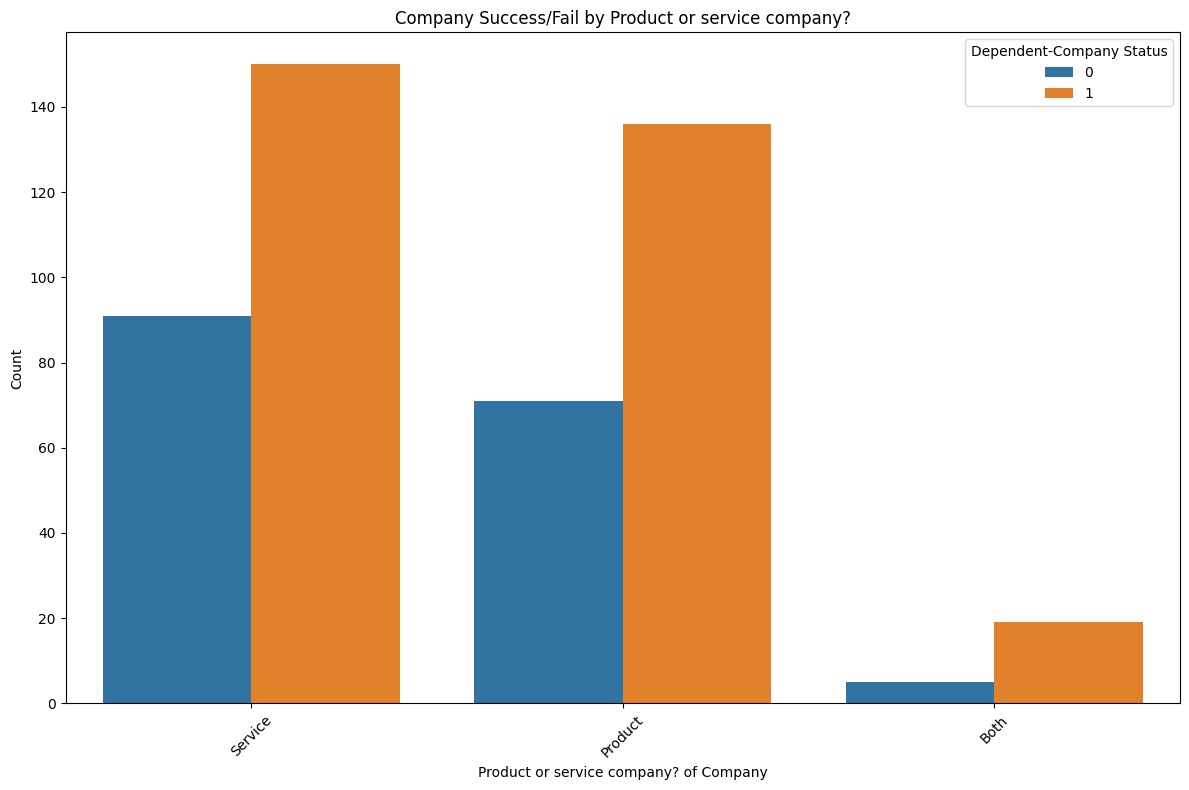

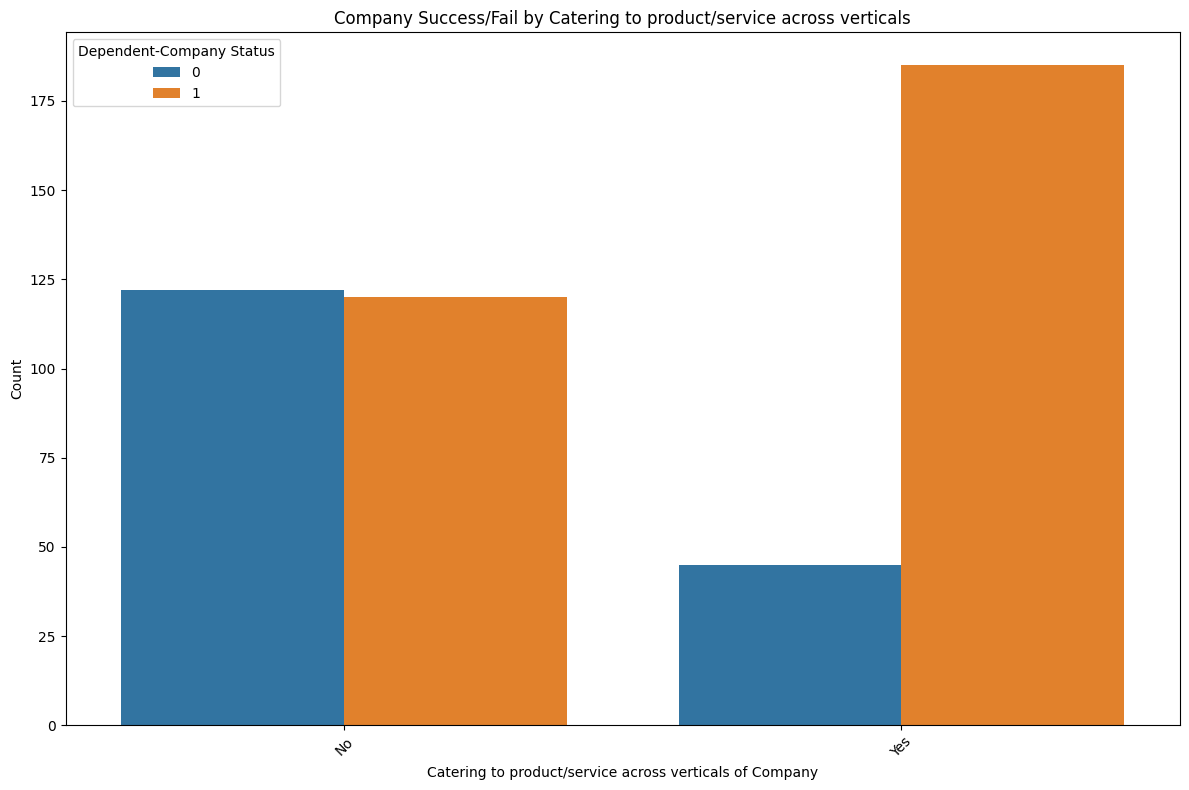

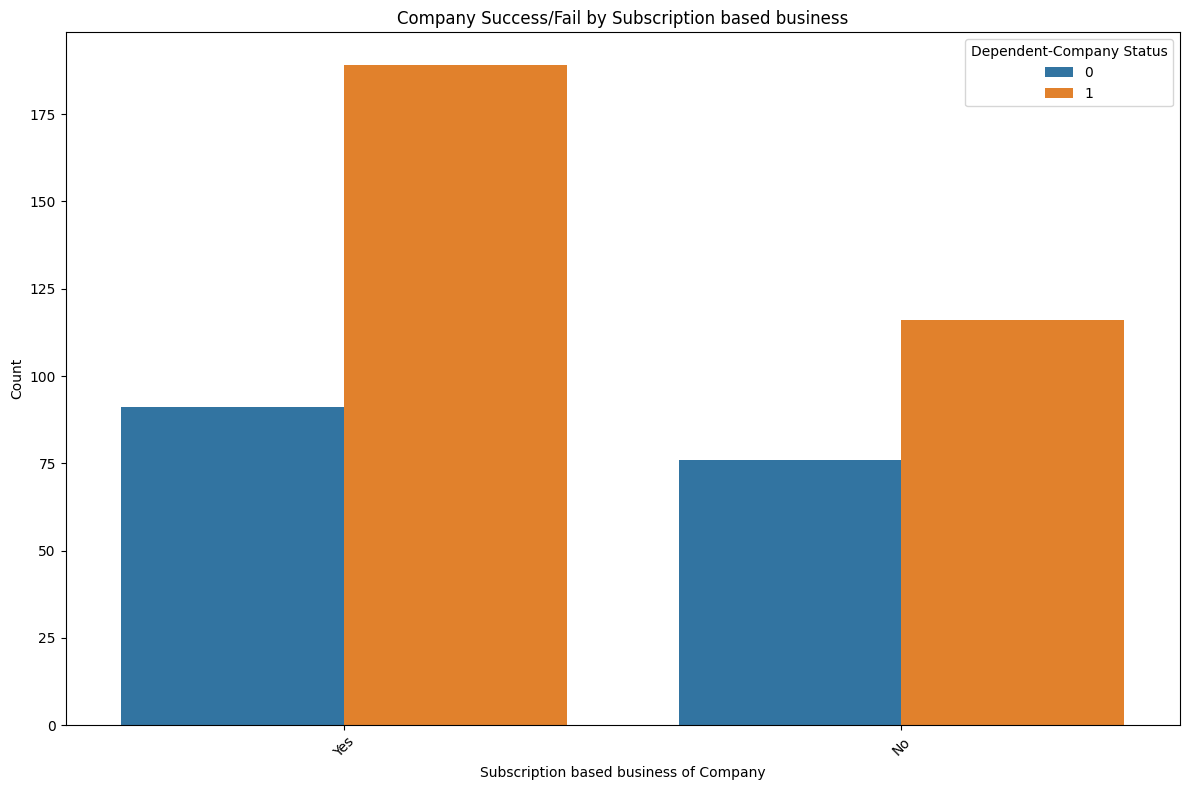

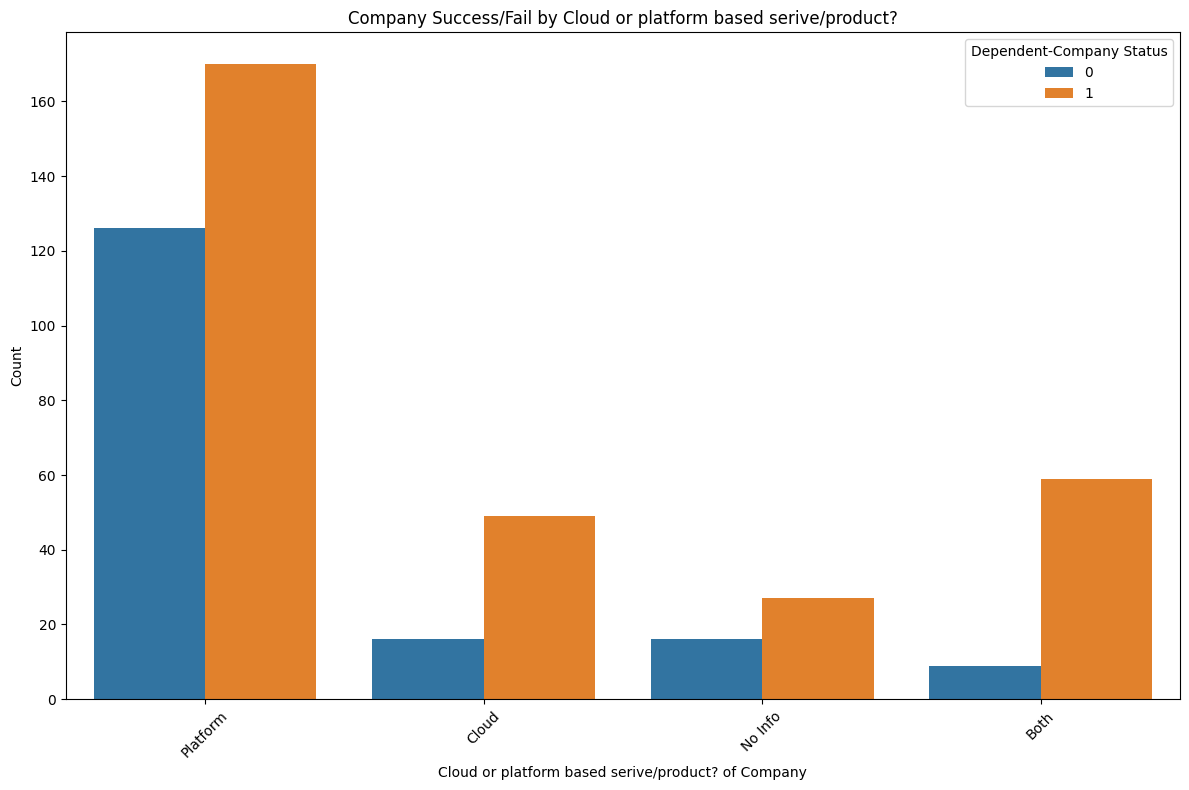

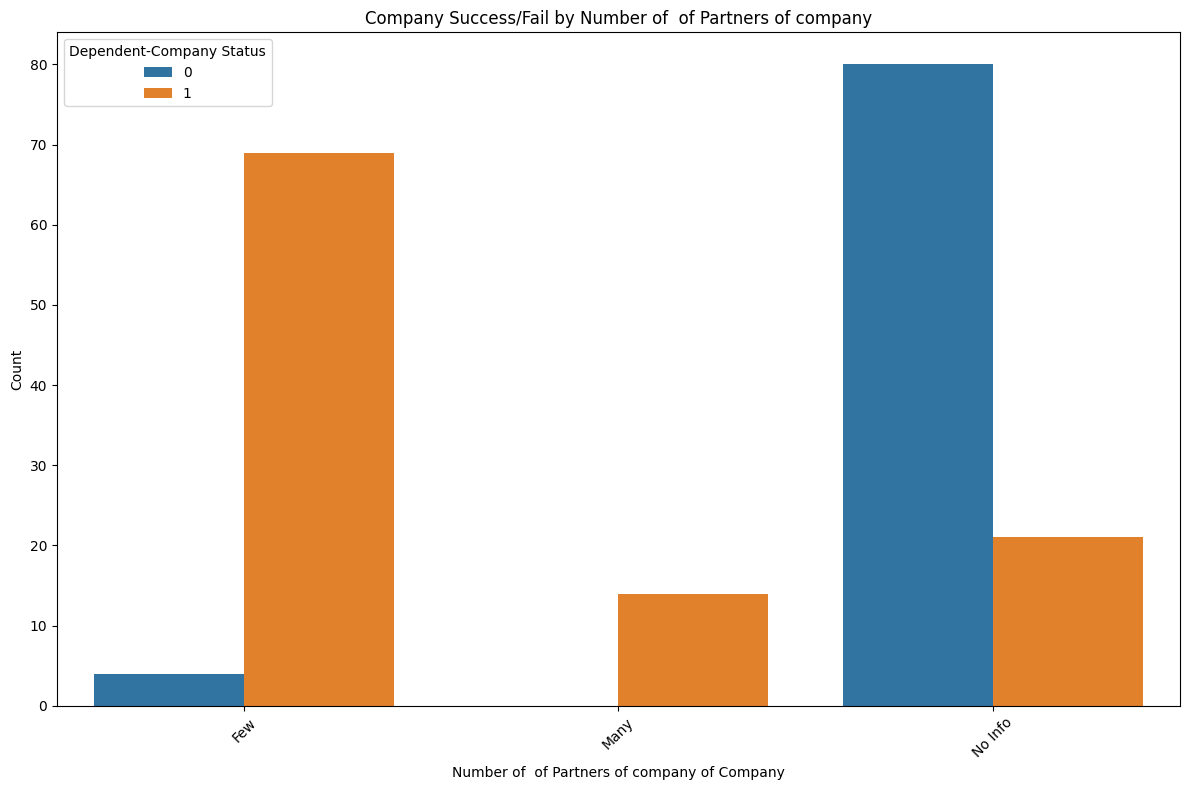

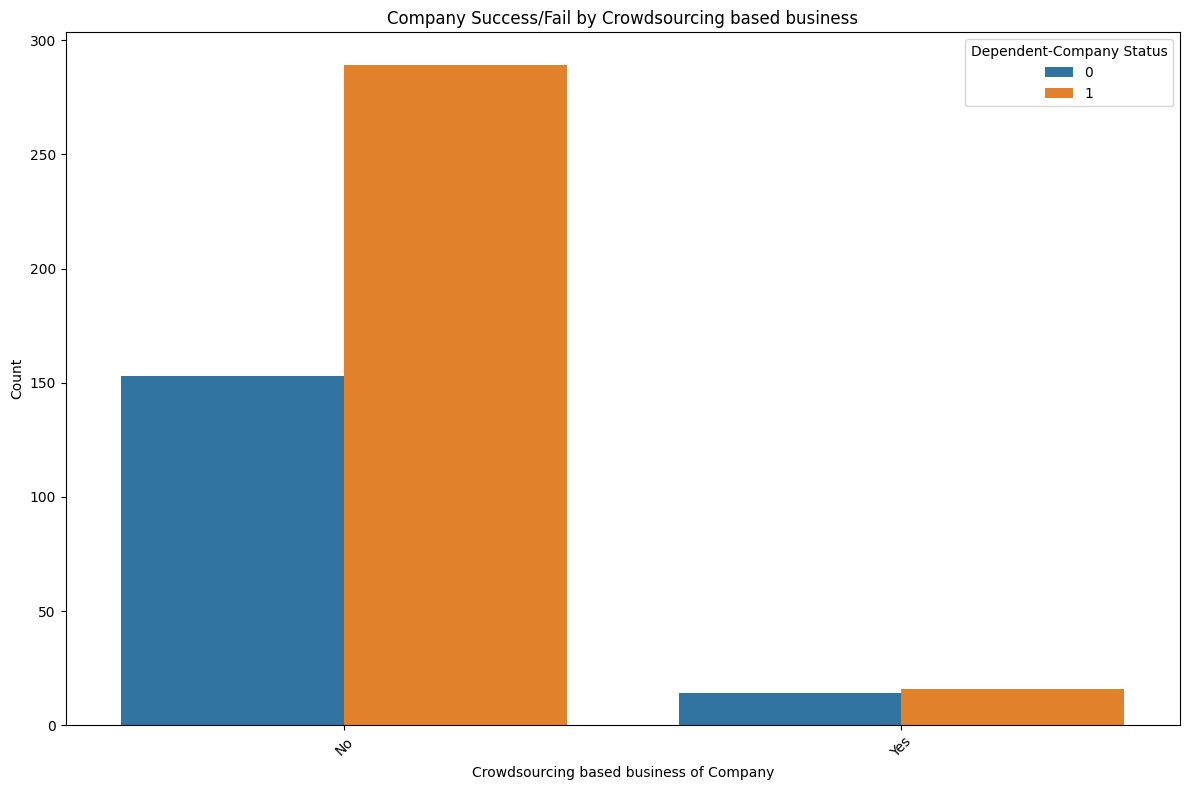

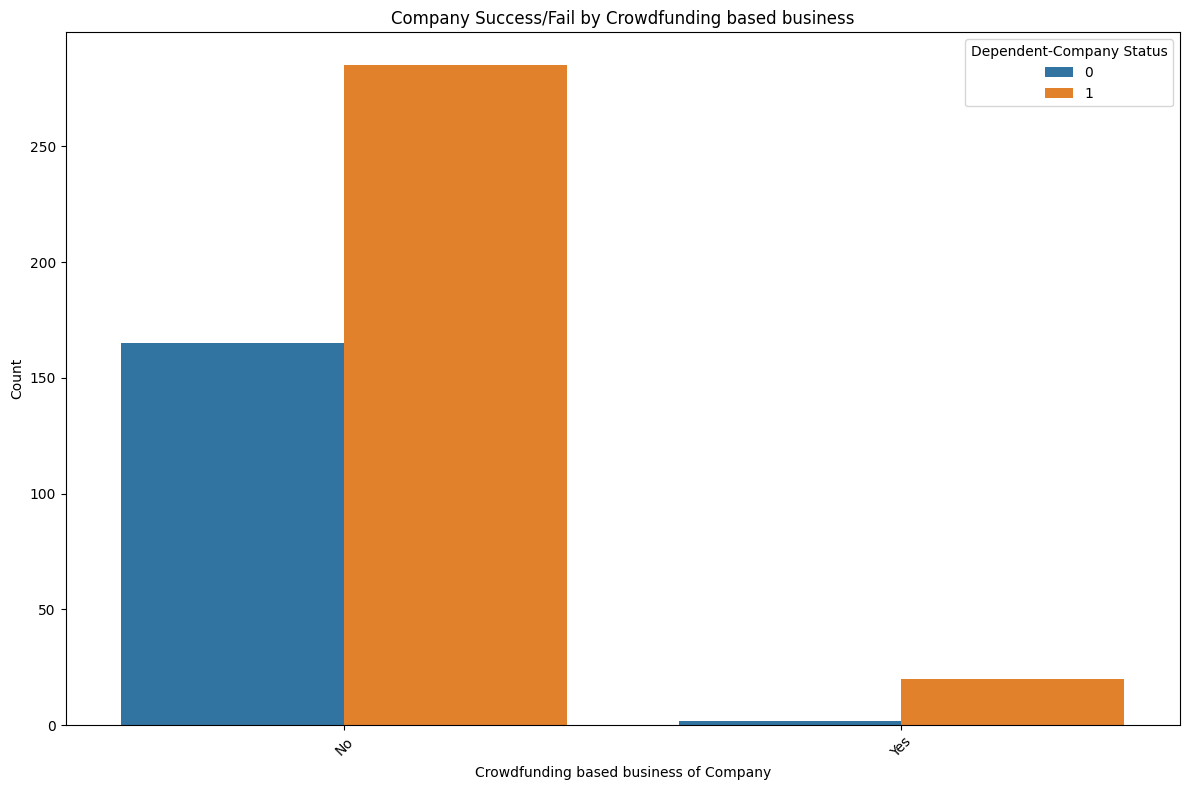

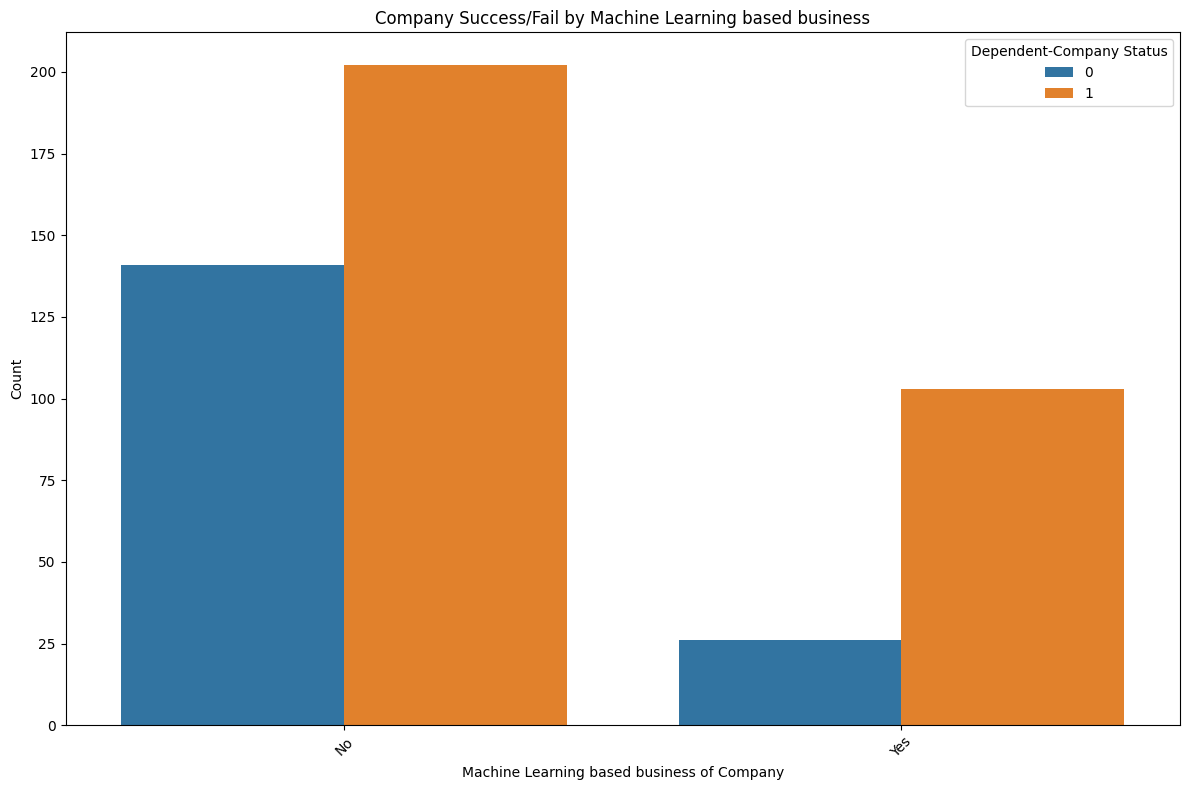

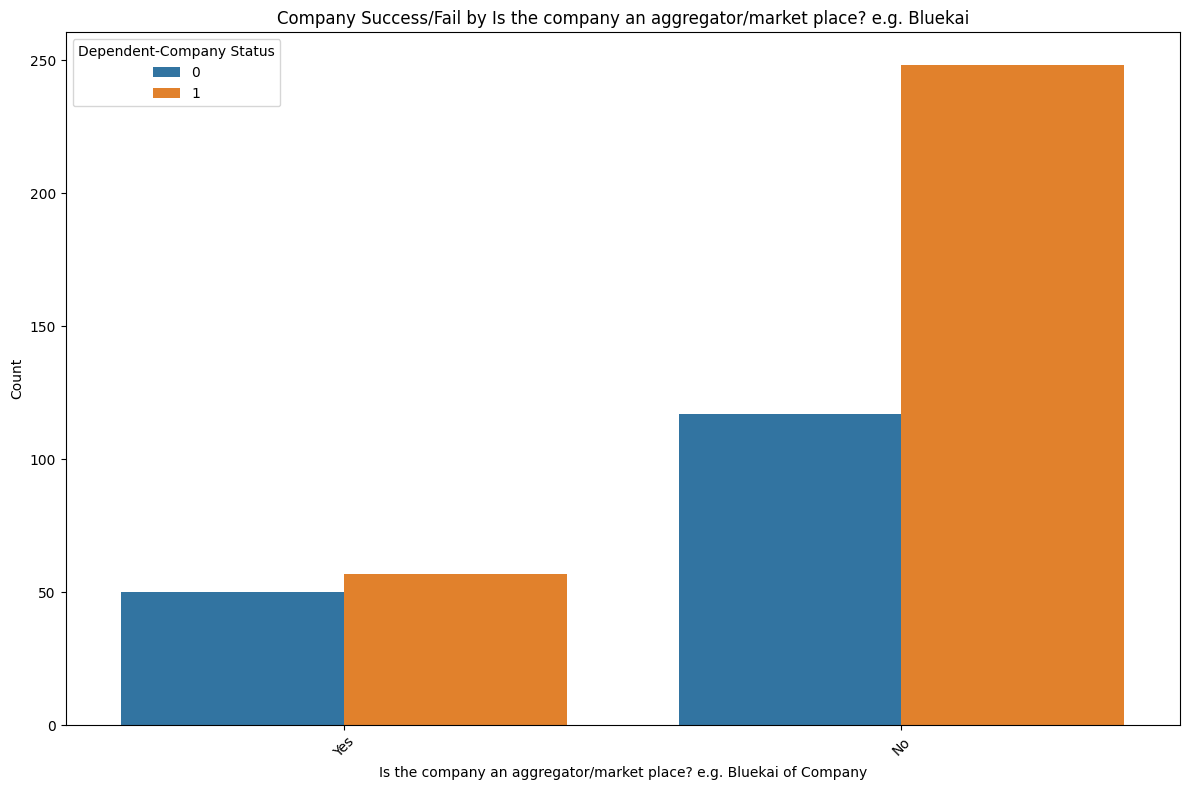

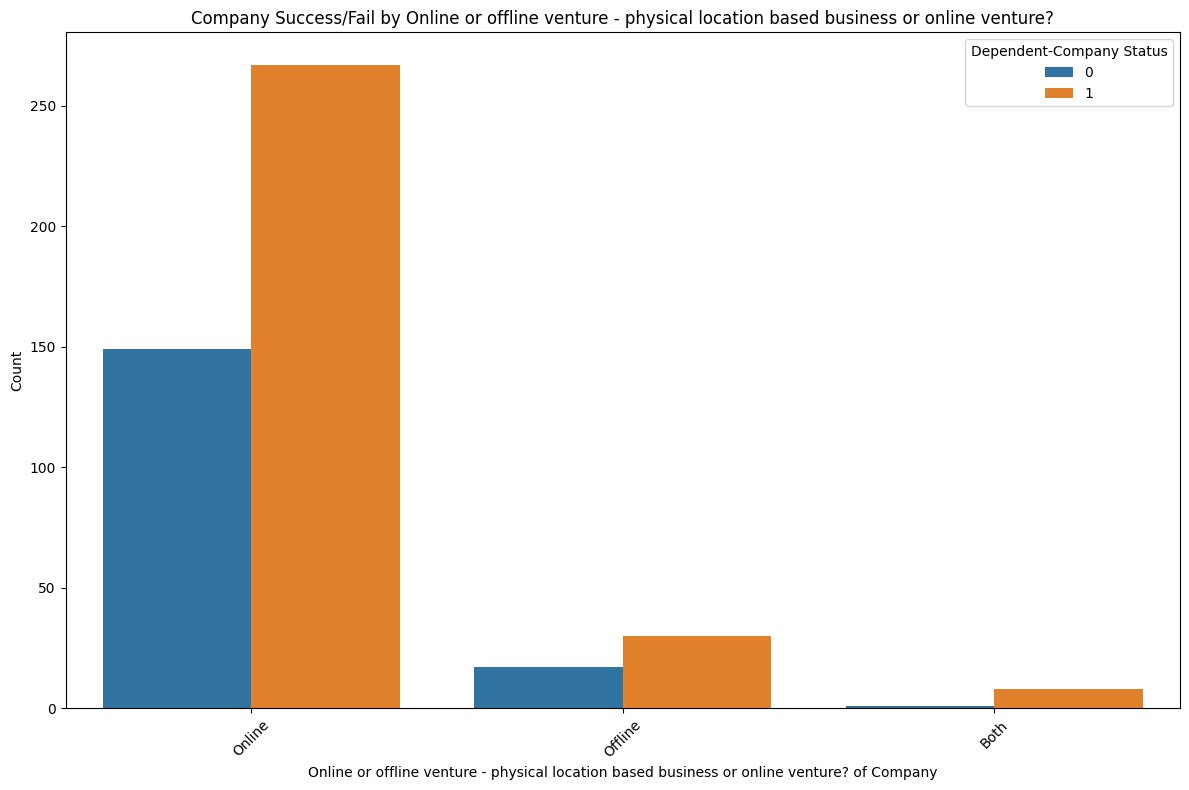

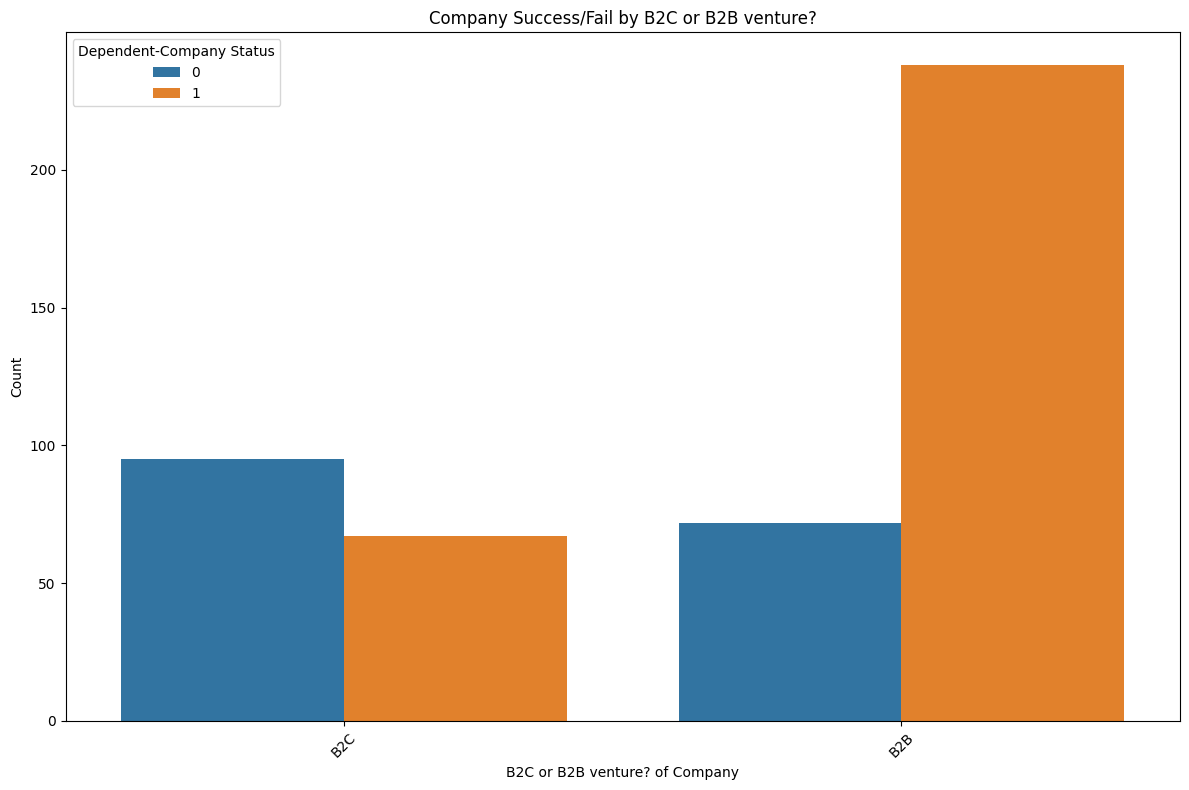

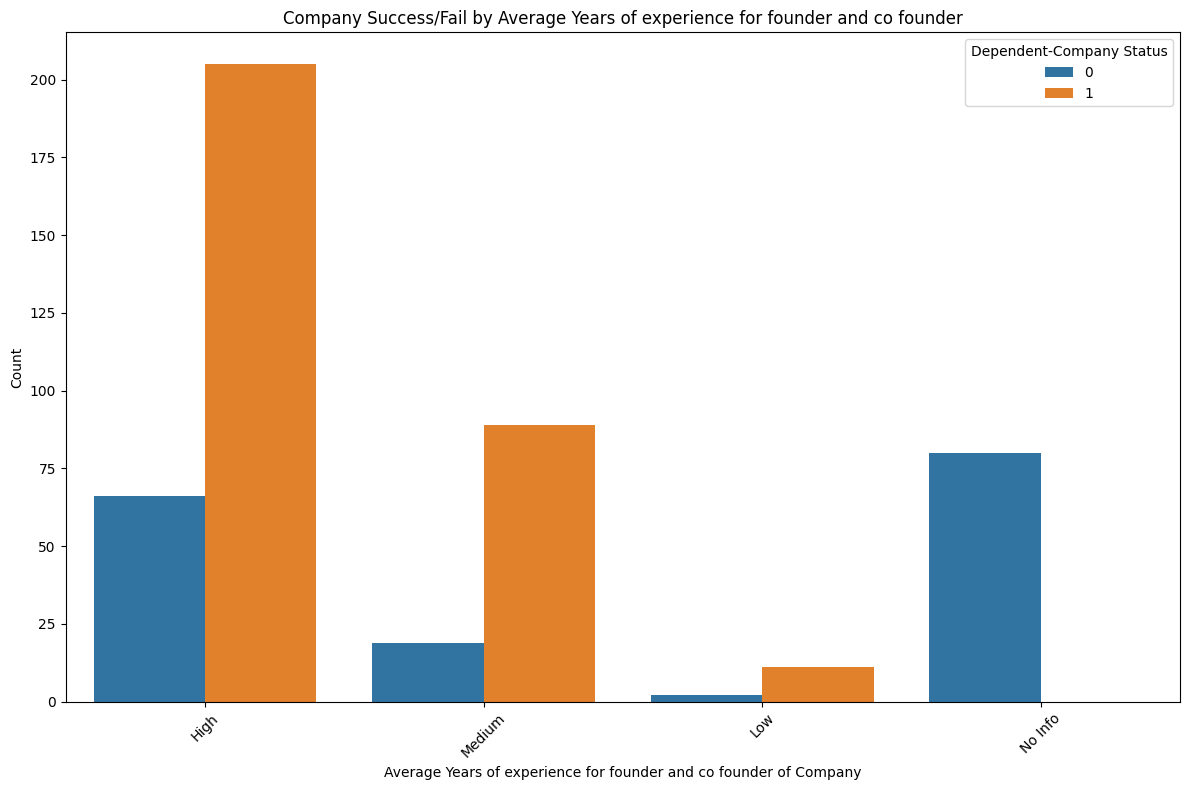

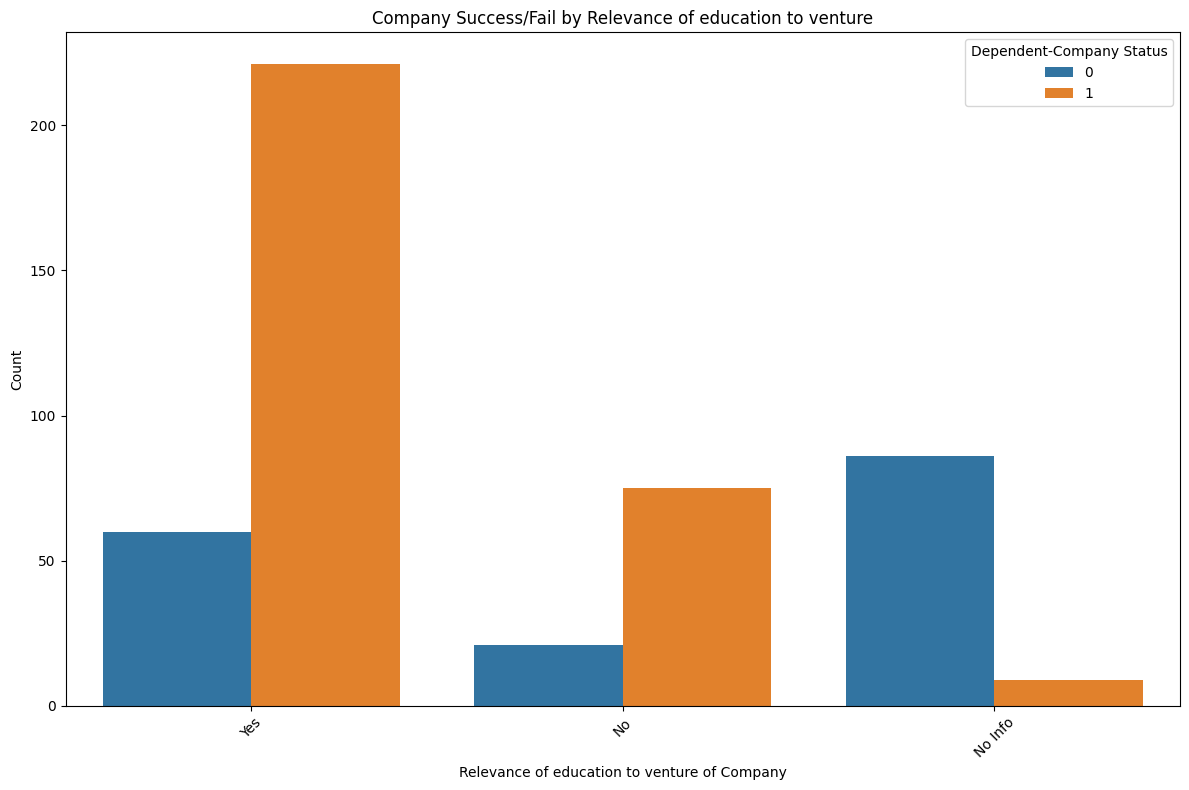

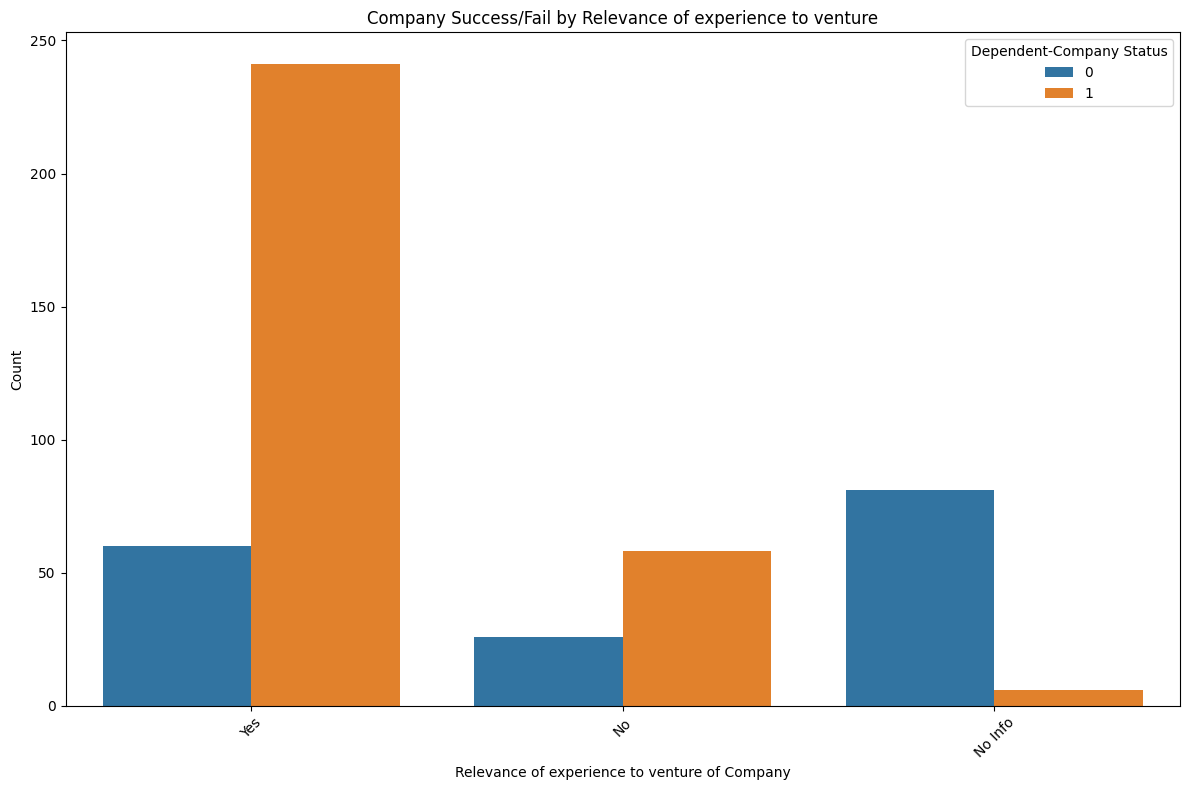

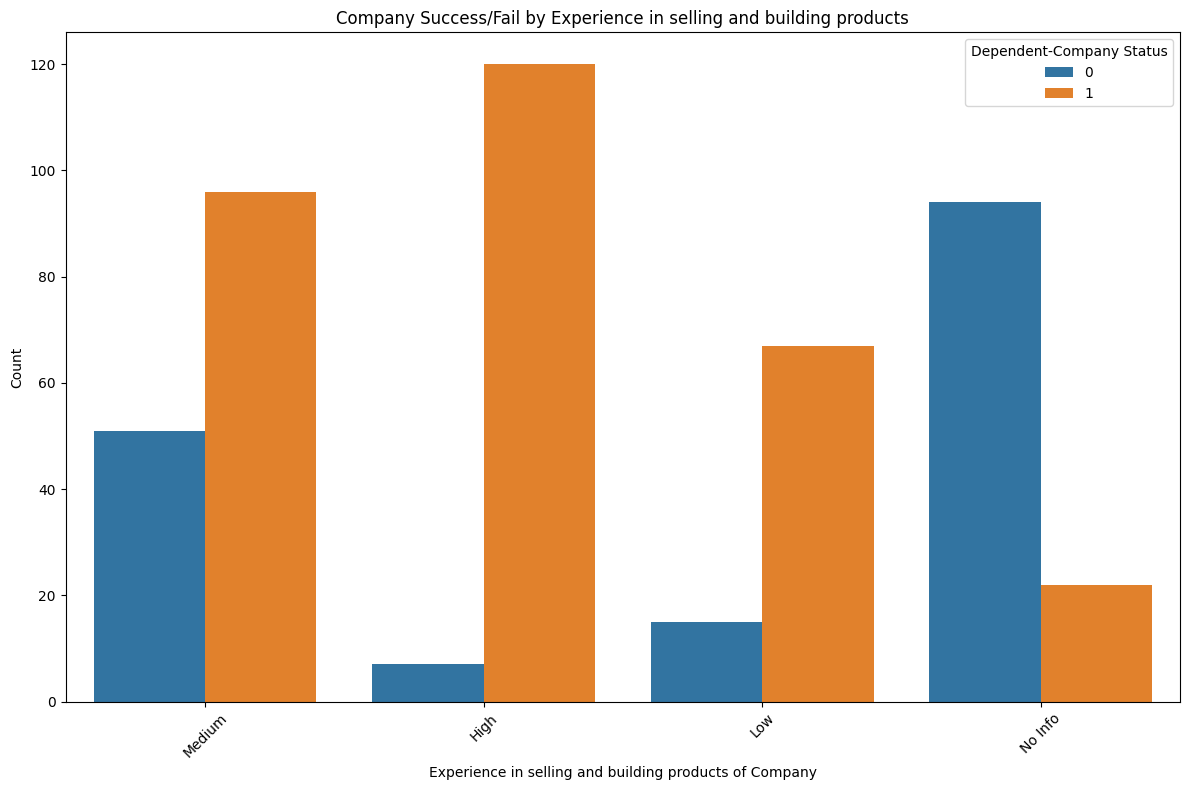

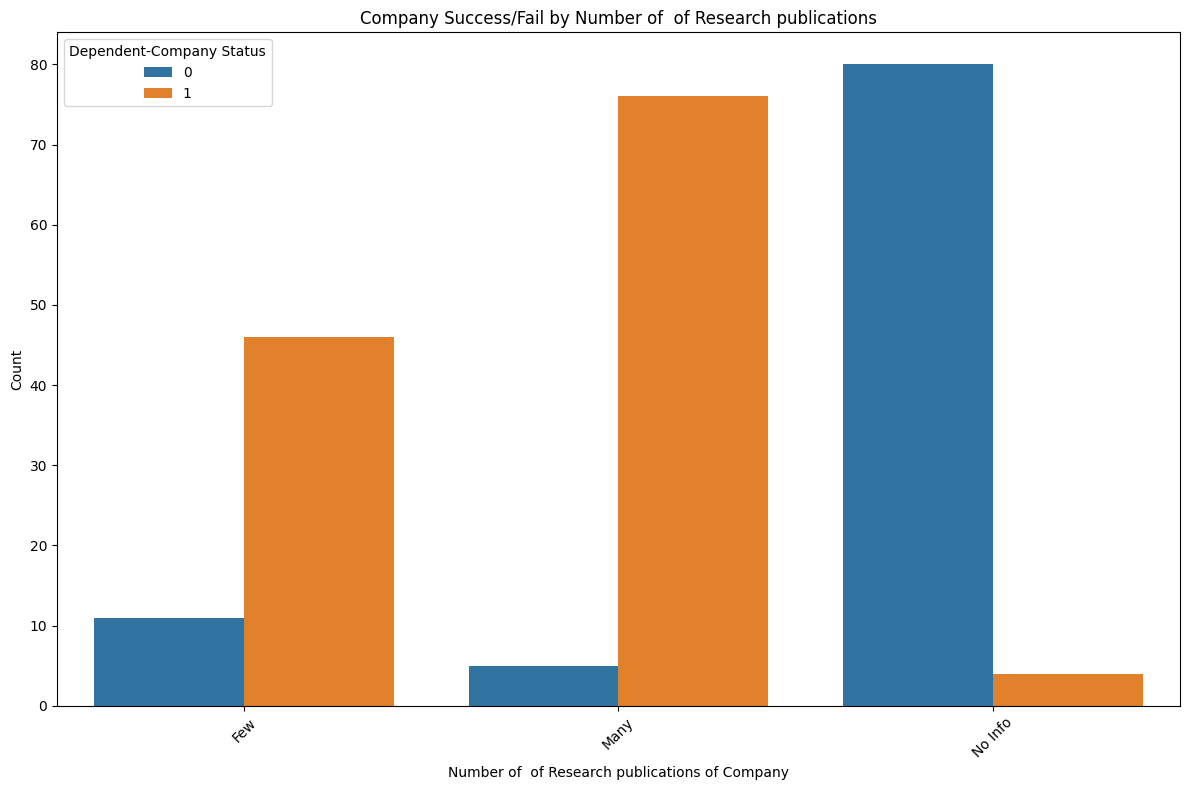

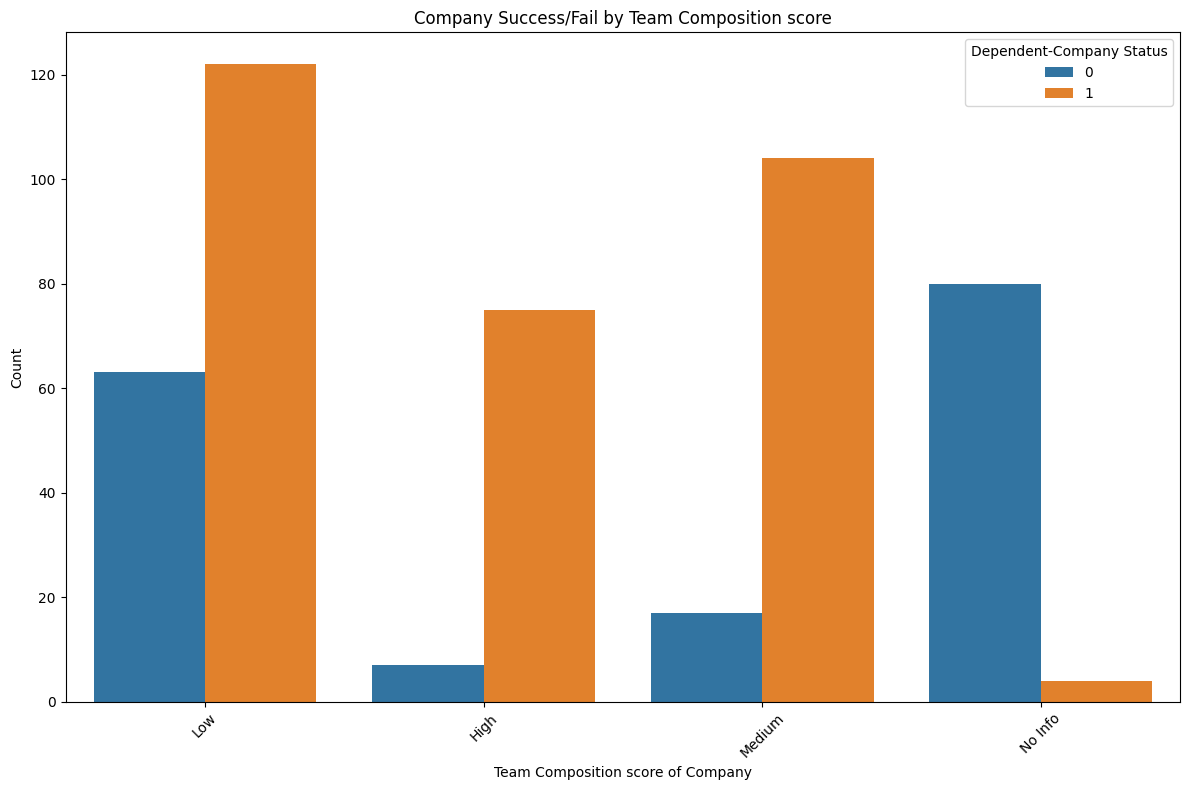

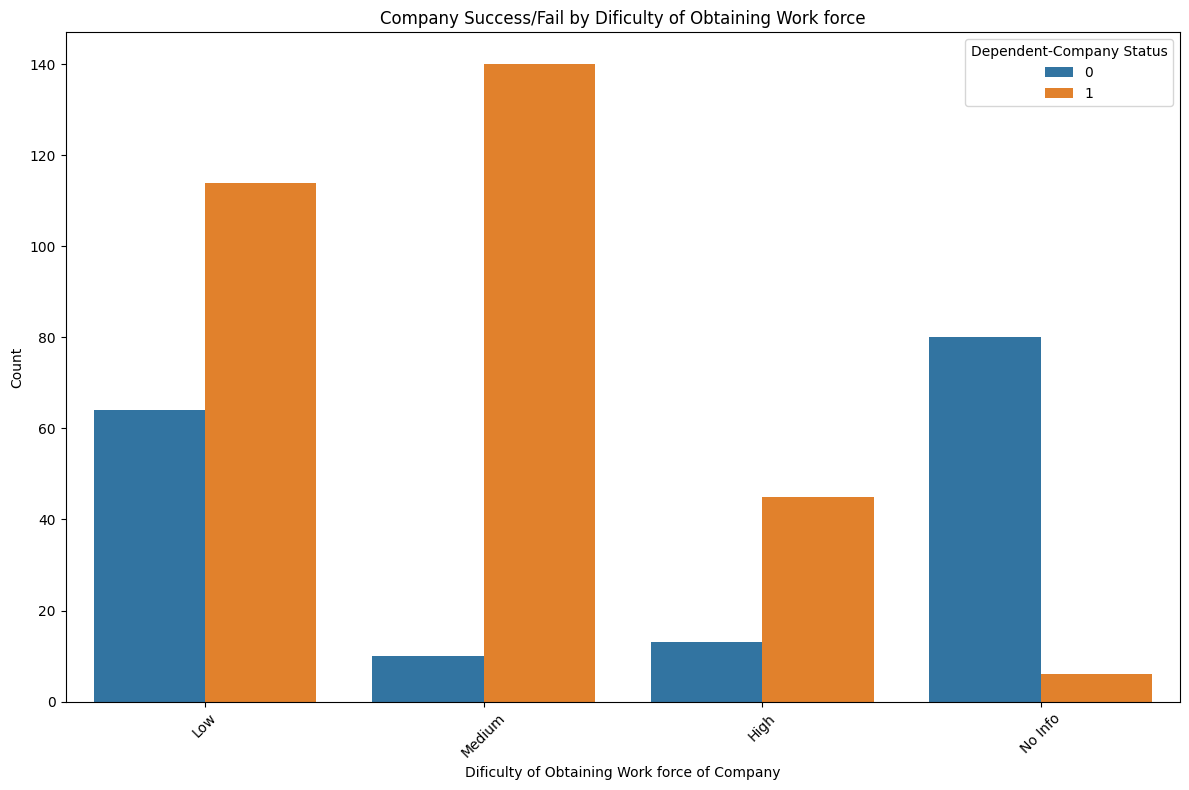

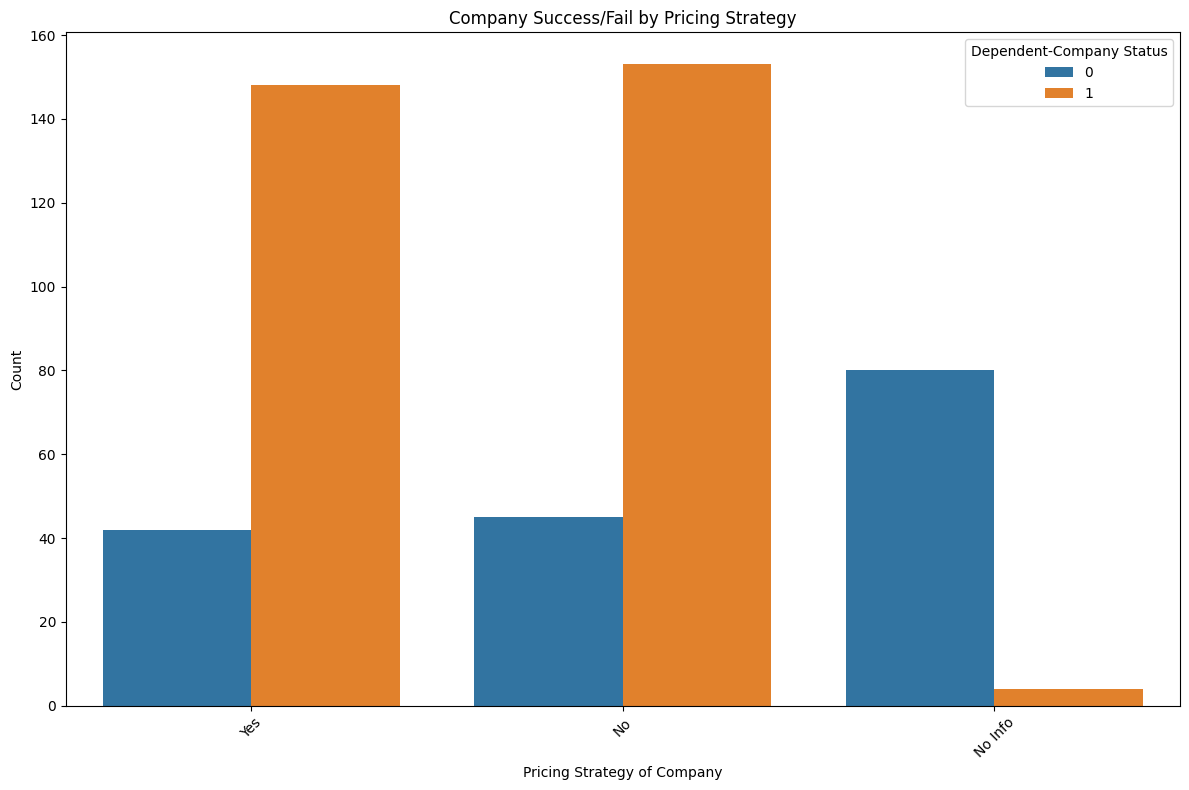

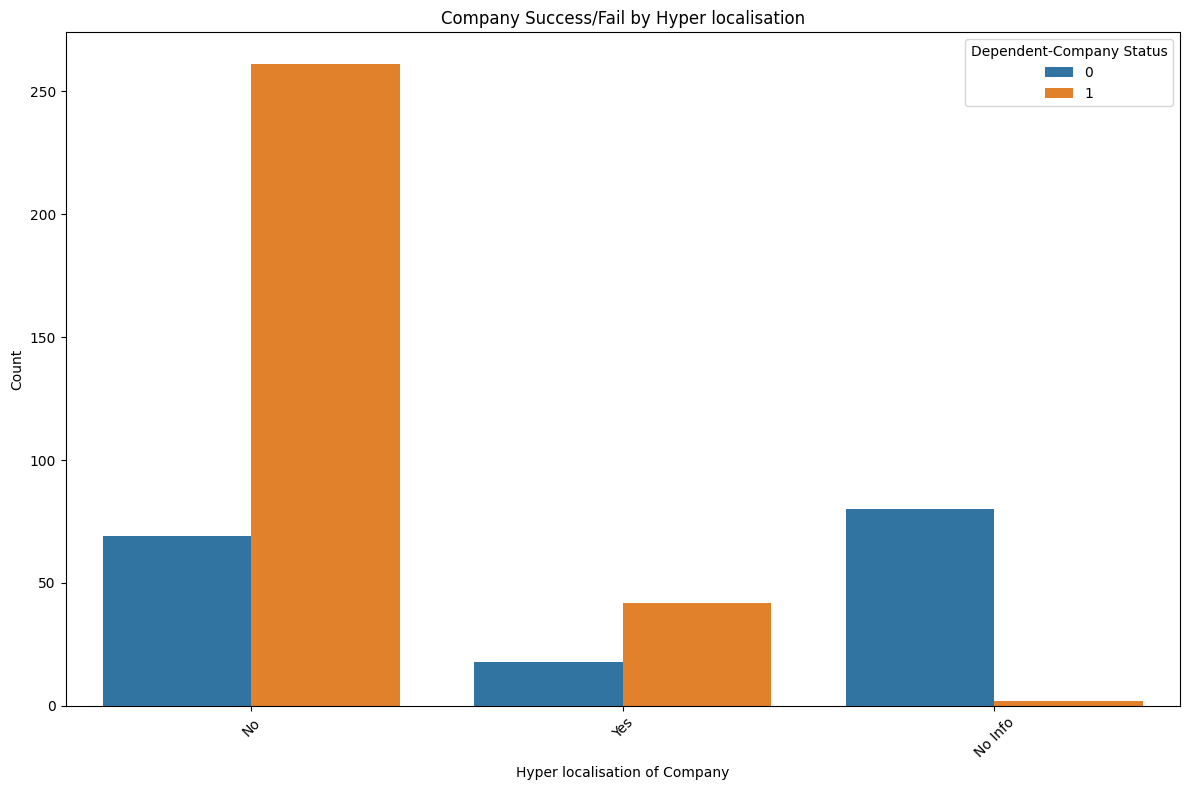

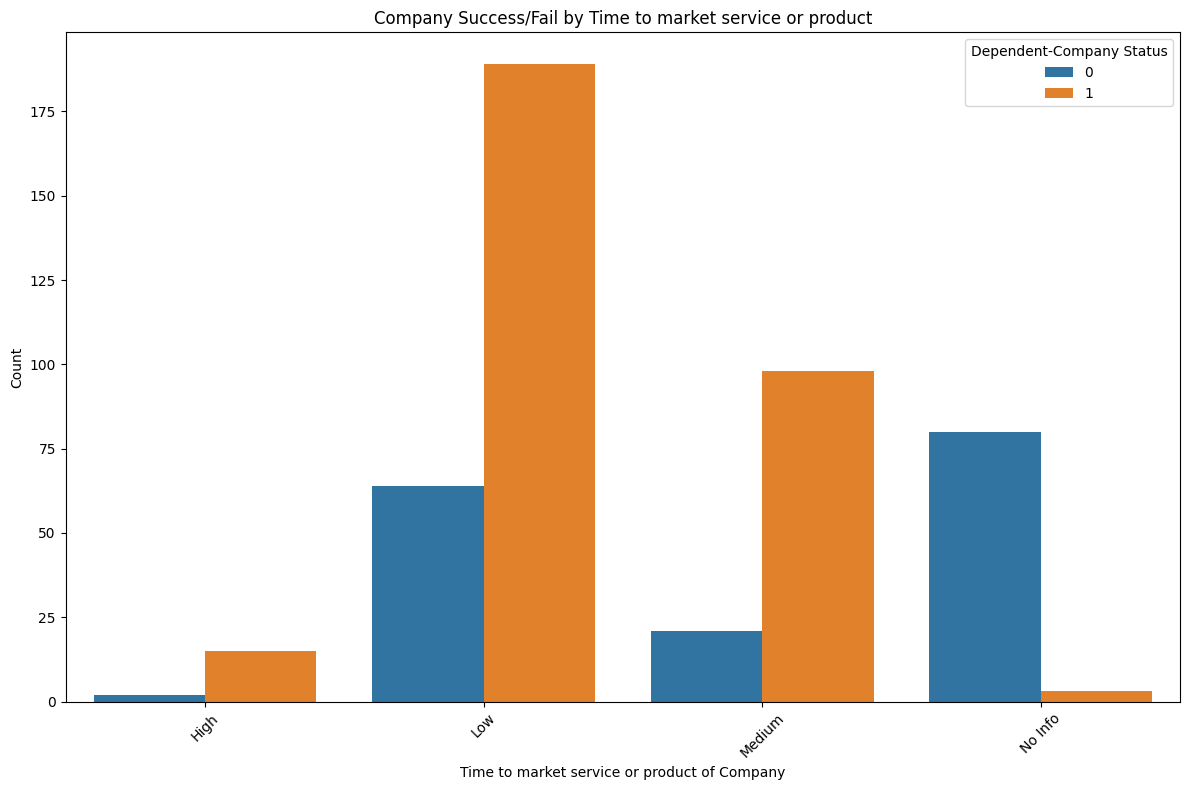

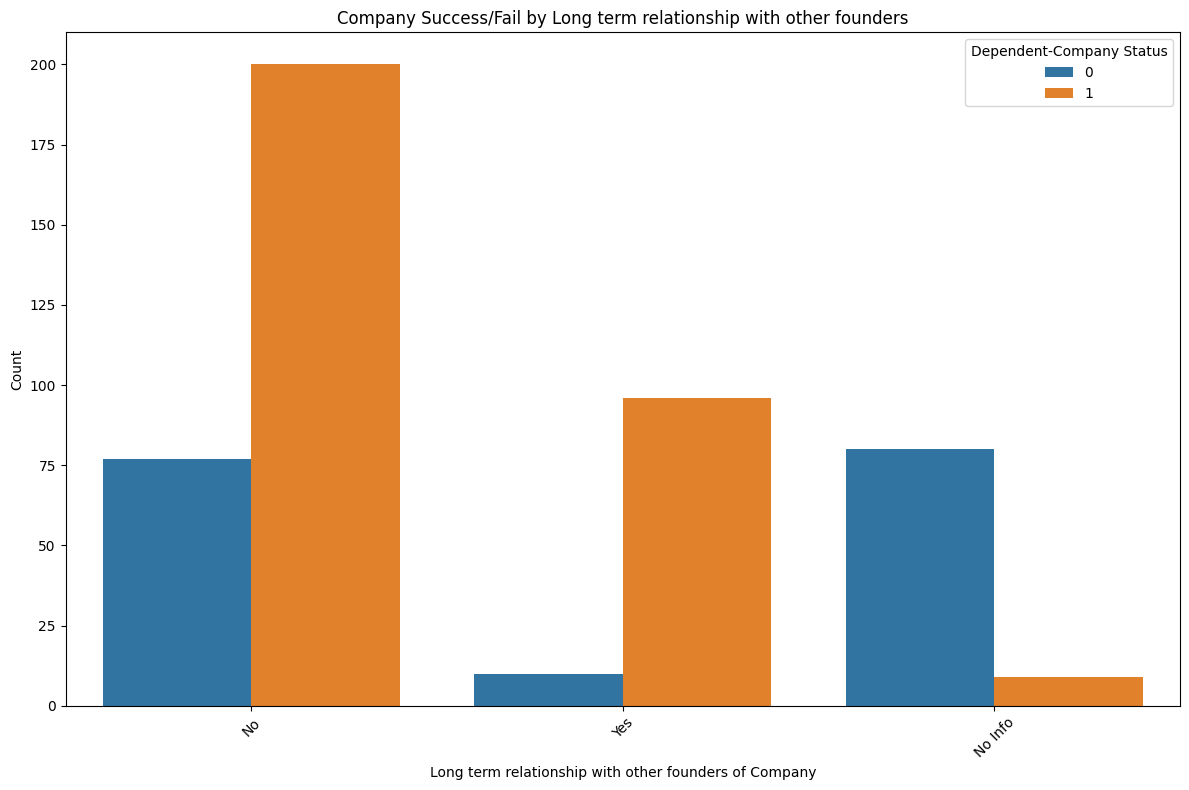

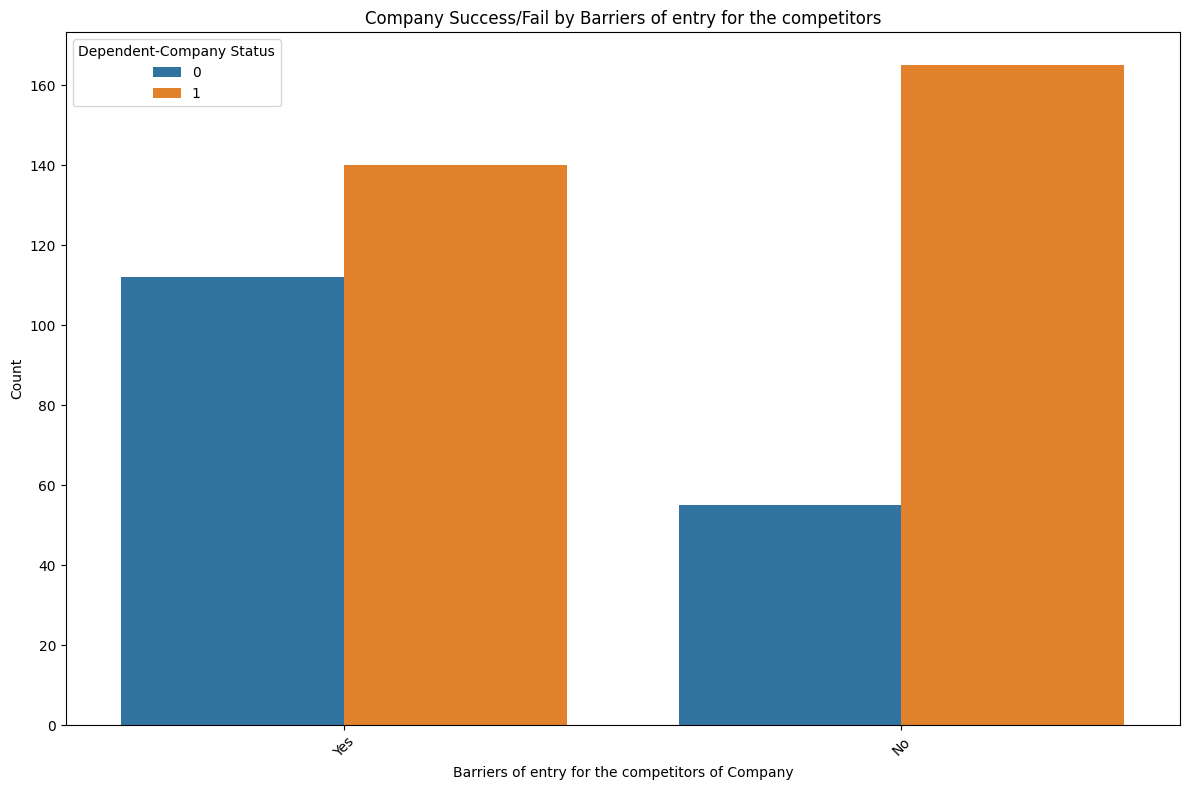

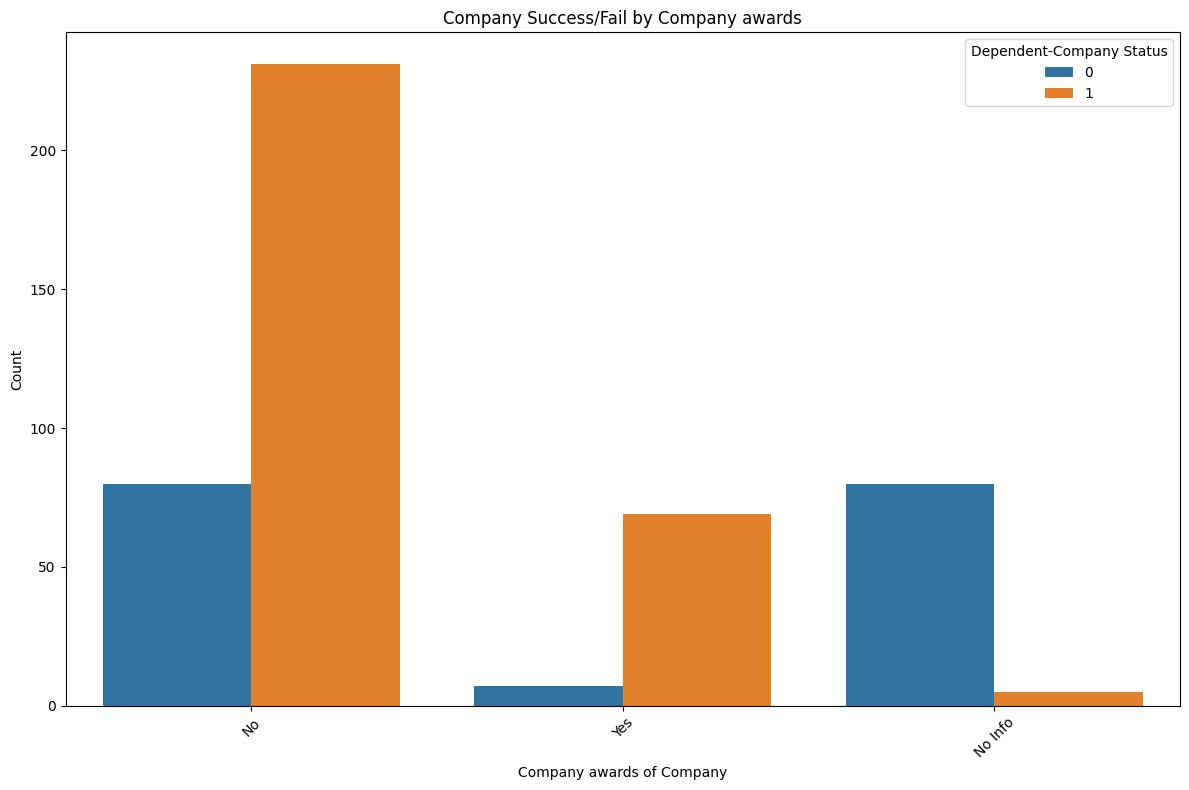

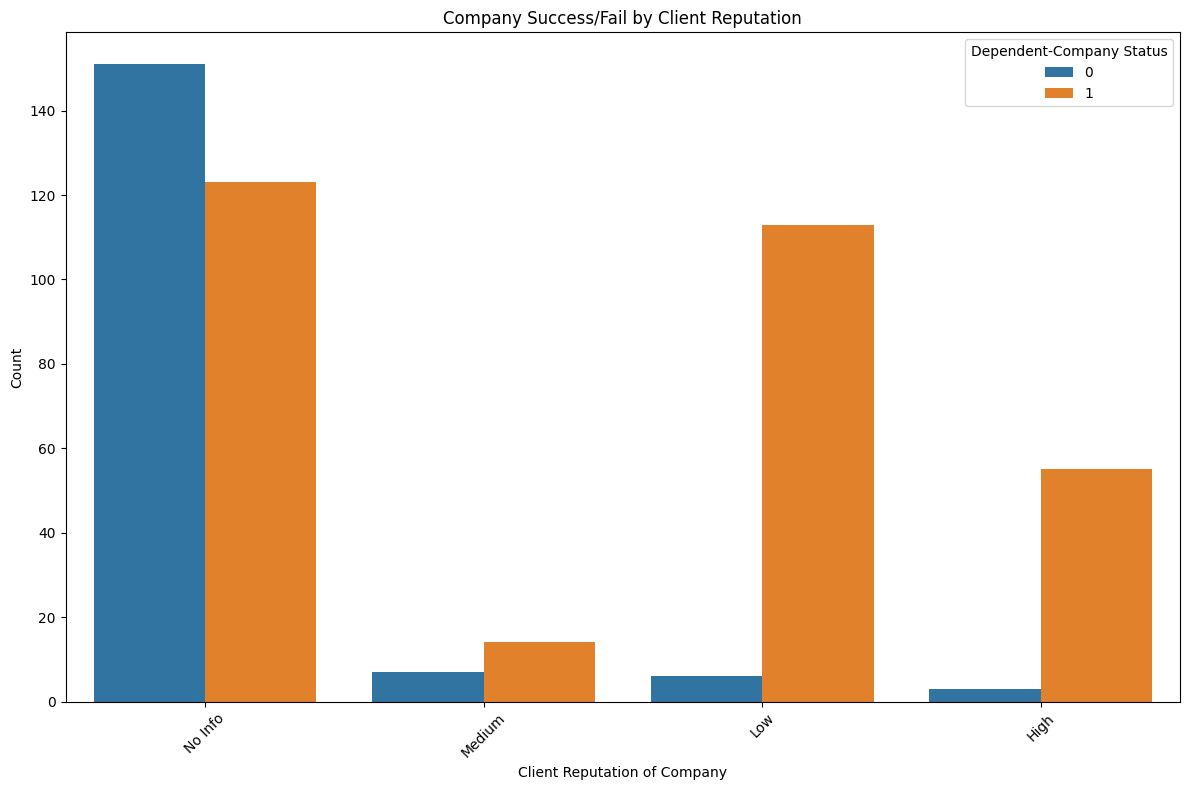

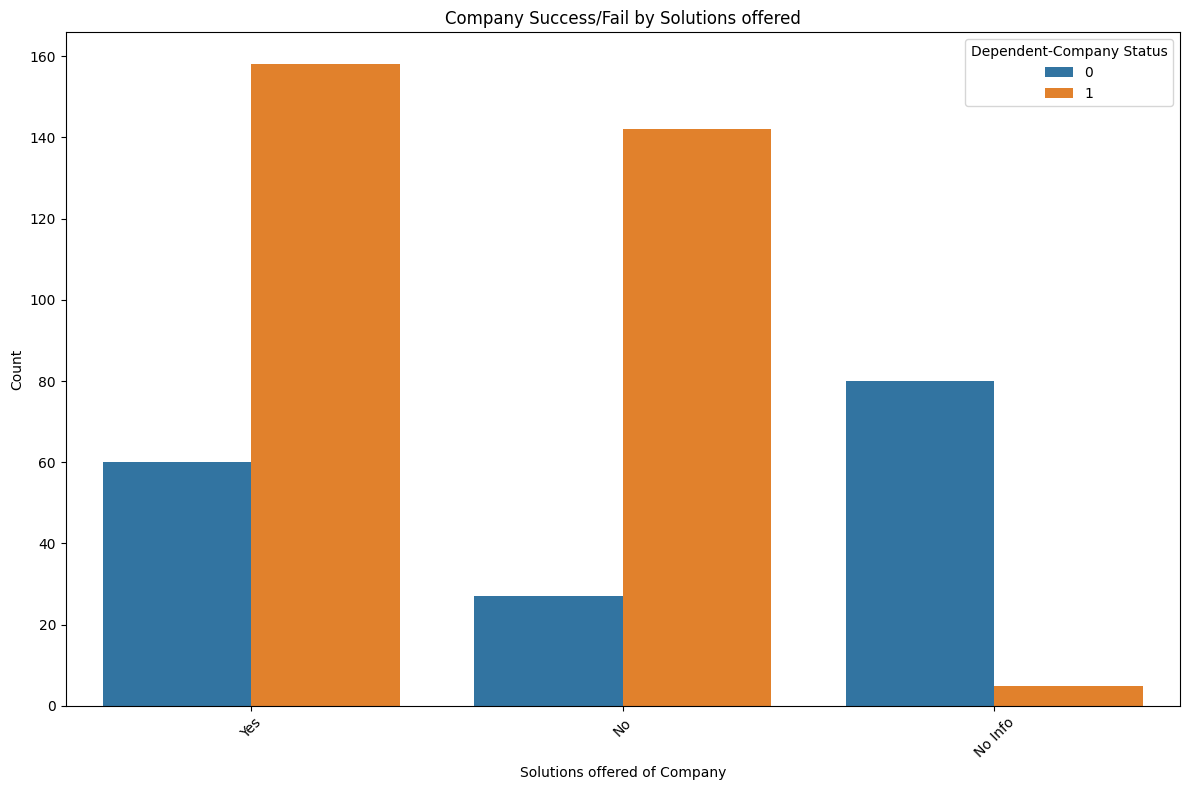

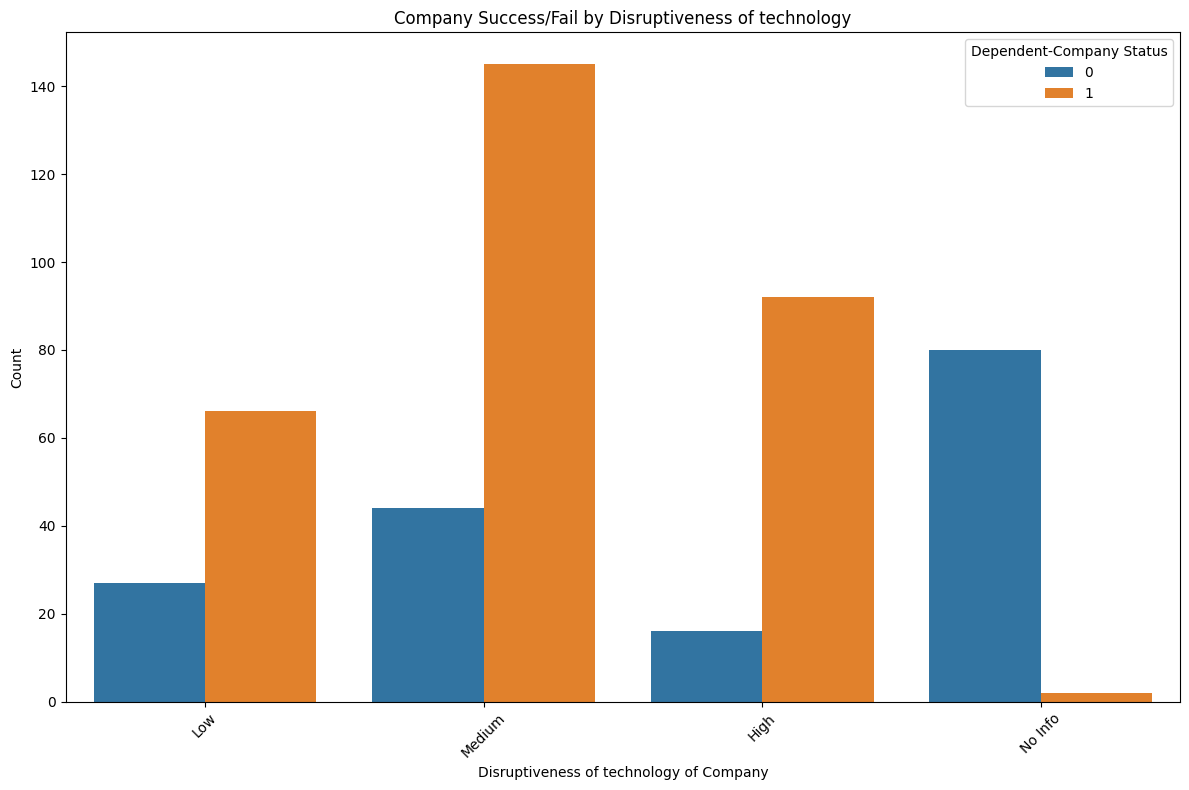

In [ ]:
for column in startups_categorical:
  plt.figure(figsize=(12, 8))
  sns.countplot(data=startups, x=column, hue='Dependent-Company Status')
  plt.title(f'Company Success/Fail by {column}')
  plt.xticks(rotation=45)
  plt.xlabel(f'{column}')
  plt.ylabel('Count')

  plt.tight_layout()
  plt.show()